In [24]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
from pref_voting.analysis import *
from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *

from pref_voting.utility_profiles import UtilityProfile

from pref_voting.generate_utility_profiles import *
from pref_voting.generate_utility_profiles import *
from pref_voting.utility_methods import *

from pref_voting.spatial_profiles import SpatialProfile
from pref_voting.generate_spatial_profiles import *
from pref_voting.utility_functions import *
from pref_voting.probabilistic_methods import *
from tqdm.notebook import tqdm
import nashpy as nash
import numpy as np
import random2 as random
from multiprocess import Pool, cpu_count, current_process


In [ ]:
# Simple Stable Voting 
def _simple_stable_voting(edata, 
                          curr_cands, 
                          strength_function,
                          mem_sv_winners, 
                          sorted_matches):
    
    sv_winners = list()
        
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    
    margin_witnessing_win = -math.inf

    for a, b, s in sorted_matches:
        if s < margin_witnessing_win: 
            break
        if a not in sv_winners: 
            cands_minus_b = [c for c in curr_cands if c != b]
            cands_minus_b_key = tuple(sorted(cands_minus_b))
            if cands_minus_b_key not in mem_sv_winners.keys(): 
                ws, mem_sv_winners = _simple_stable_voting(edata, 
                                                           curr_cands = cands_minus_b,
                                                           strength_function = strength_function,
                                                           mem_sv_winners = mem_sv_winners, 
                                                           sorted_matches = [(a, c, s) for a, c, s in sorted_matches if c != b and a != b])
                mem_sv_winners[cands_minus_b_key] = ws
            else: 
                ws = mem_sv_winners[cands_minus_b_key]
            if a in ws:
                sv_winners.append(a)
                margin_witnessing_win = s

    return sv_winners, mem_sv_winners
    
@vm(name = "Simple Stable Voting")
def simple_stable_voting(edata, curr_cands = None, strength_function = None): 
   
    
    curr_cands = edata.candidates if curr_cands is None else curr_cands
    strength_function = edata.margin if strength_function is None else strength_function  

    matches = [(a, b, strength_function(a, b)) for a in curr_cands for b in curr_cands if a != b]
    sorted_matches = sorted(matches, reverse=True, key=lambda m_w_weight: m_w_weight[2])
    
    return sorted(_simple_stable_voting(edata, 
                                        curr_cands = curr_cands, 
                                        strength_function = strength_function,
                                        mem_sv_winners = {}, 
                                        sorted_matches = sorted_matches)[0])


In [7]:
cov_m = generate_covariance_matrix(30)

In [13]:
random_var = multivariate_normal(None, cov_m)

In [20]:
print(random_var.rvs())

[ 1.52822088e-01  8.87166702e-02  2.24228438e+00 -2.28850000e-01
  1.43824798e+00  1.10558645e+00  8.22062532e-01  8.28458491e-01
  4.16994405e-01  1.61002026e+00  2.73512214e-01  1.13396758e+00
  2.49472108e-01  4.20265440e-01  2.73054212e-01  9.33988290e-01
  2.58850608e-01  2.46642848e+00  1.76259126e+00  1.04836000e+00
  7.51244535e-01  6.68048544e-01  1.25360581e-01  9.96038920e-01
  1.09592067e+00  5.11195930e-01  9.42143817e-02  2.99219789e-02
  5.48529451e-01  2.34173683e-01  2.12240528e-01 -2.33613263e+00
 -1.62776510e-01 -1.35800642e+00  8.32952694e-01  2.12124645e-01
 -5.51063245e-01  1.34168765e+00  2.15560061e-01 -3.32931468e-01
 -1.30680763e+00 -3.60506291e-01  5.61424717e-01  1.03278616e+00
 -2.30678737e-01  1.42872327e+00  4.83861042e-01 -3.54667324e-01
  5.44863258e-01  8.25627150e-01 -8.89179825e-02  5.95323896e-01
  1.60365194e+00  1.18988242e+00 -1.13331279e-01 -5.79763829e-01
  3.77829103e-01  1.60089913e-01  7.43867972e-01  4.12062007e-01
  1.25302926e-01  6.03374

In [15]:
%timeit [multivariate_normal(None, cov_m) for _ in range(100)]

11.8 s ± 2.37 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
random.permutation(range(10))


AttributeError: module 'random2' has no attribute 'permutation'

In [ ]:
%timeit multivariate_normal(None, cov_m)

In [12]:
%timeit [generate_edge_ordered_tournament_infinite_limit(30) for _ in range(100)]

1min 19s ± 3.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit [generate_edge_ordered_tournament_infinite_limit(30, cov_matrix = cov_m) for _ in range(100)]

1.33 s ± 248 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
random.uniform(0.001, 0.999)

0.24299350955087196

In [27]:
def find_best_response(uprof, vm):

    u0 = uprof.utilities[0]
    prof = uprof.to_ranking_profile().to_linear_profile()
    rankings = prof.rankings
    ws = vm(prof)
    eu_ws = np.average([u0(w) for w in ws])
    best_rankings = list()
    current_best_eu = eu_ws
    for new_ranking in permutations(prof.candidates):
        new_prof = Profile([new_ranking] + rankings[1:])
        new_ws = vm(new_prof)
        new_eu_ws = np.average([u0(w) for w in new_ws])
        if new_eu_ws > current_best_eu:
            current_best_eu = new_eu_ws
            best_rankings = [new_ranking]
        elif new_eu_ws == current_best_eu:
            best_rankings.append(new_ranking)
    return best_rankings


In [28]:
uprof = generate_utility_profile_uniform(3, 4)

uprof.display()

prof = uprof.to_ranking_profile().to_linear_profile()
prof.display()
plurality.display(prof)
find_best_response(uprof, plurality)

  Voter         0         1          2
-------  --------  --------  ---------
      1  0.342644  0.416331  0.274456
      2  0.916936  0.575516  0.0826836
      3  0.772727  0.986005  0.933072
      4  0.889942  0.380999  0.176628
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 0 | 1 | 0 |
| 0 | 1 | 2 | 1 |
| 2 | 2 | 0 | 2 |
+---+---+---+---+
Plurality winners are {0, 1}


[(1, 0, 2), (1, 2, 0)]

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 3 | 3 | 2 | 0 |
| 0 | 0 | 1 | 3 | 1 |
| 3 | 1 | 2 | 1 | 2 |
| 1 | 2 | 0 | 0 | 3 |
+---+---+---+---+---+


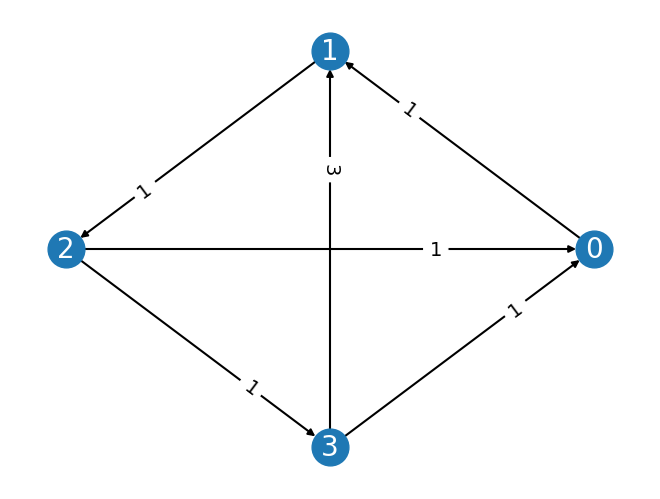

{0: 7, 1: 6, 2: 8, 3: 9}
c_ws [2, 3]
c_b_ws [2]
c_gb_ws [3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 1 | 0 | 1 | 0 |
| 0 | 2 | 2 | 2 | 3 |
| 3 | 0 | 1 | 3 | 1 |
| 1 | 3 | 3 | 0 | 2 |
+---+---+---+---+---+


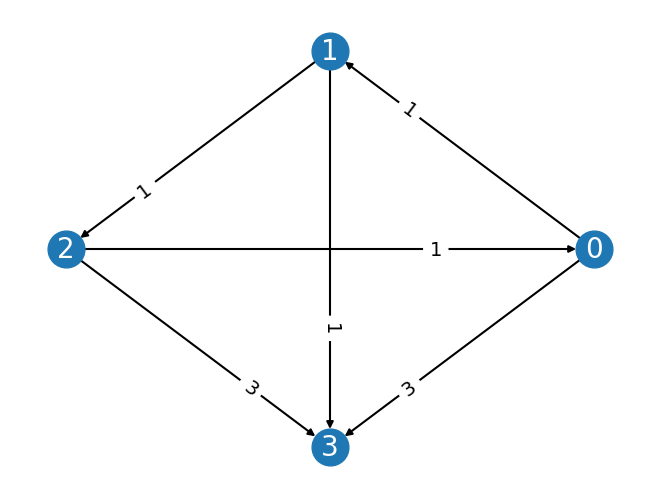

{0: 9, 1: 8, 2: 9, 3: 4}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [0, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 0 | 1 | 0 | 3 |
| 1 | 1 | 2 | 1 | 2 |
| 0 | 3 | 3 | 2 | 0 |
| 2 | 2 | 0 | 3 | 1 |
+---+---+---+---+---+


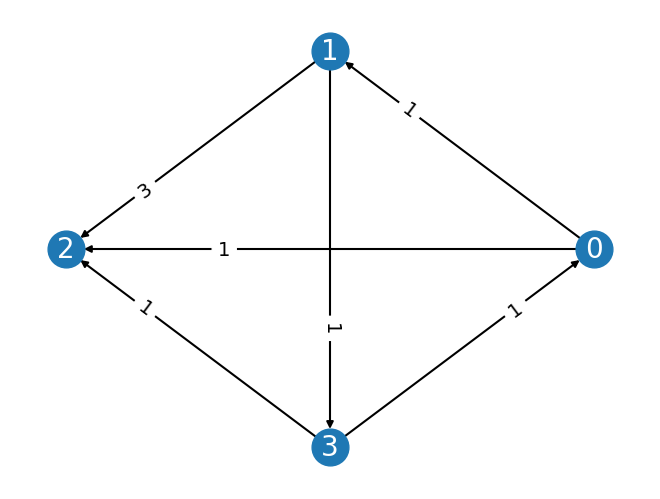

{0: 8, 1: 9, 2: 5, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 3 | 1 | 1 | 0 |
| 3 | 2 | 2 | 2 | 3 |
| 2 | 1 | 0 | 3 | 1 |
| 1 | 0 | 3 | 0 | 2 |
+---+---+---+---+---+


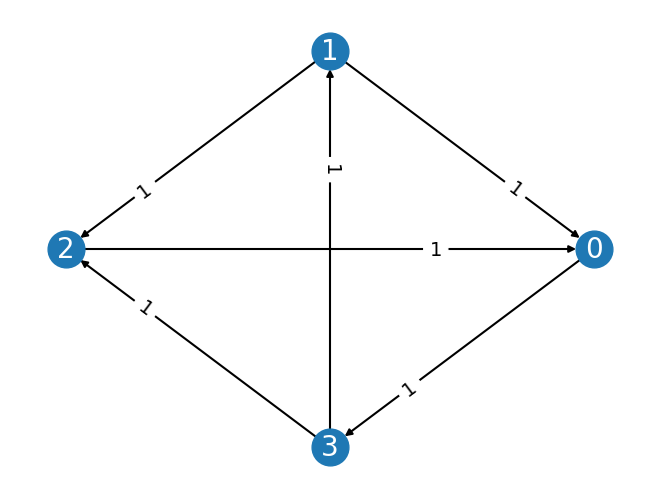

{0: 7, 1: 8, 2: 7, 3: 8}
c_ws [1, 3]
c_b_ws [3]
c_gb_ws [1, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 1 | 3 | 0 | 1 |
| 2 | 0 | 1 | 3 | 2 |
| 1 | 3 | 2 | 1 | 0 |
| 0 | 2 | 0 | 2 | 3 |
+---+---+---+---+---+


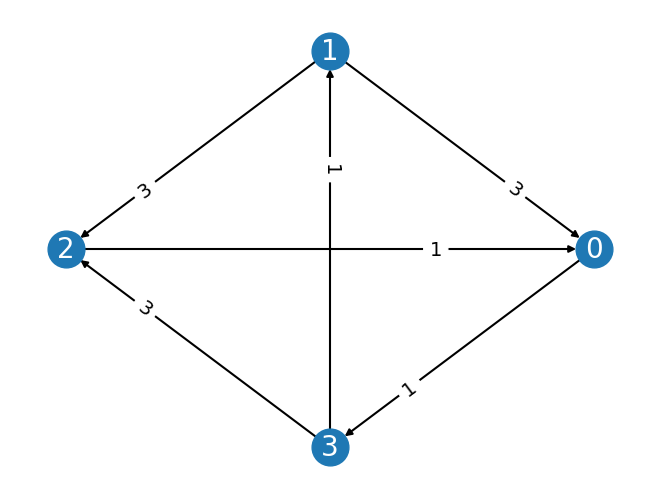

{0: 6, 1: 10, 2: 5, 3: 9}
c_ws [1, 3]
c_b_ws [3]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 1 | 1 | 0 | 2 |
| 0 | 2 | 0 | 3 | 0 |
| 3 | 0 | 2 | 1 | 1 |
| 1 | 3 | 3 | 2 | 3 |
+---+---+---+---+---+


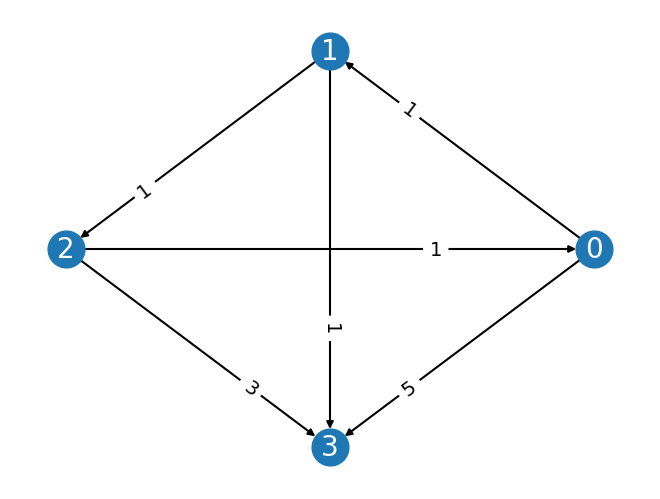

{0: 10, 1: 8, 2: 9, 3: 3}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [0]
+---+---+---+---+
| 1 | 1 | 2 | 1 |
+---+---+---+---+
| 1 | 1 | 3 | 2 |
| 0 | 0 | 2 | 0 |
| 3 | 2 | 0 | 1 |
| 2 | 3 | 1 | 3 |
+---+---+---+---+


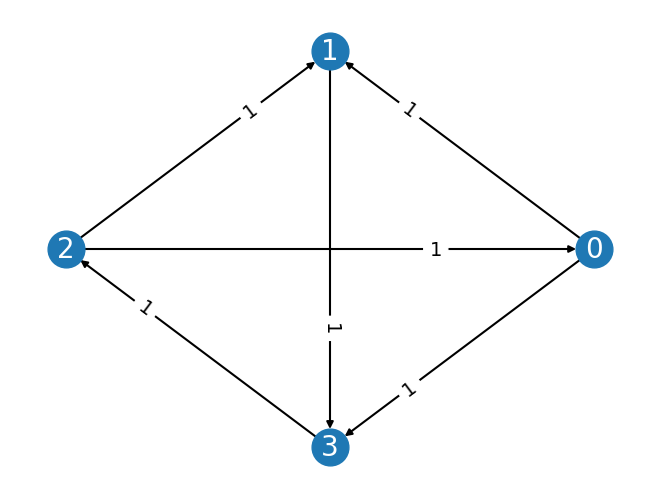

{0: 8, 1: 7, 2: 8, 3: 7}
c_ws [0, 2]
c_b_ws [2]
c_gb_ws [0, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 0 | 1 | 2 | 3 |
| 2 | 1 | 3 | 1 | 2 |
| 3 | 3 | 0 | 0 | 1 |
| 1 | 2 | 2 | 3 | 0 |
+---+---+---+---+---+


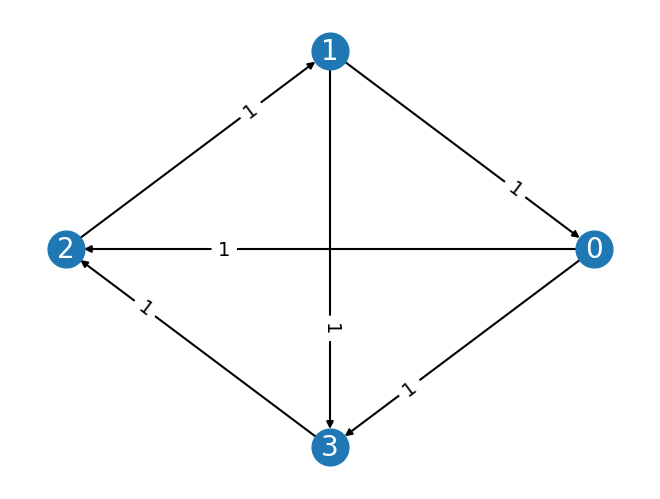

{0: 8, 1: 8, 2: 7, 3: 7}
c_ws [0, 1]
c_b_ws [1]
c_gb_ws [0, 1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 3 | 3 | 0 | 1 |
| 3 | 2 | 0 | 1 | 2 |
| 0 | 0 | 1 | 2 | 3 |
| 1 | 1 | 2 | 3 | 0 |
+---+---+---+---+---+


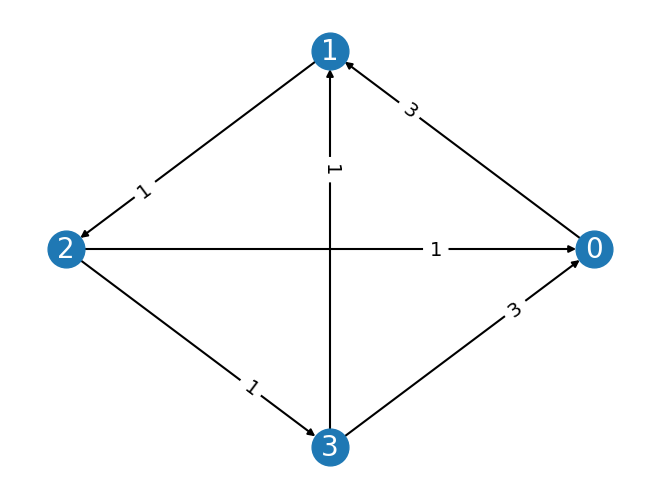

{0: 7, 1: 6, 2: 8, 3: 9}
c_ws [2, 3]
c_b_ws [2]
c_gb_ws [3]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 0 | 1 | 3 | 3 |
| 3 | 0 | 0 | 2 |
| 1 | 2 | 2 | 1 |
| 2 | 3 | 1 | 0 |
+---+---+---+---+


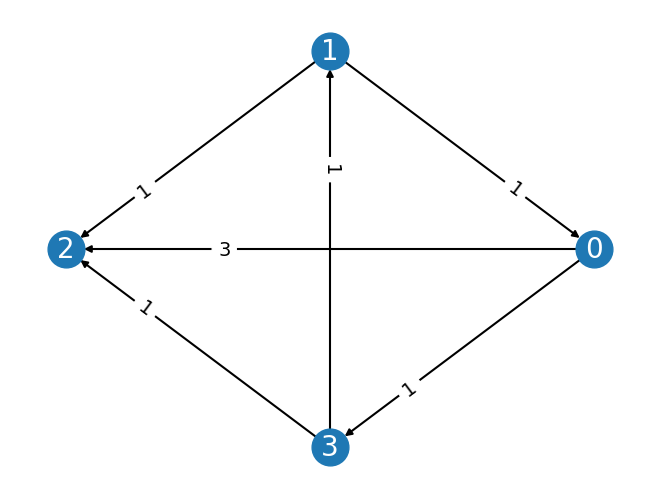

{0: 9, 1: 8, 2: 5, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 3 | 1 | 3 |
| 1 | 2 | 3 | 0 |
| 3 | 0 | 2 | 1 |
| 2 | 1 | 0 | 2 |
+---+---+---+---+


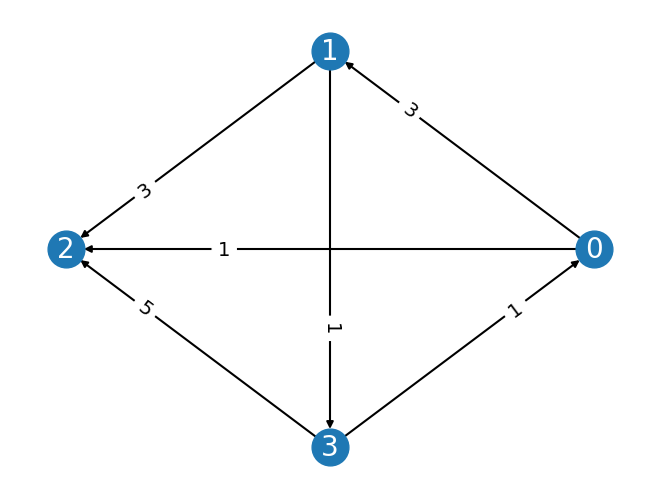

{0: 9, 1: 8, 2: 3, 3: 10}
c_ws [0, 1, 3]
c_b_ws [0]
c_gb_ws [3]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 2 | 3 | 0 |
| 2 | 3 | 0 | 3 |
| 0 | 1 | 1 | 2 |
| 3 | 0 | 2 | 1 |
+---+---+---+---+


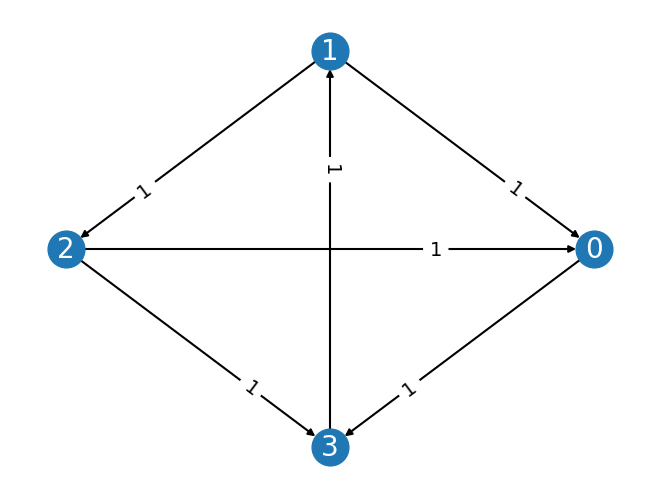

{0: 7, 1: 8, 2: 8, 3: 7}
c_ws [1, 2]
c_b_ws [1]
c_gb_ws [1, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 0 | 2 | 1 | 1 |
| 2 | 1 | 0 | 2 | 0 |
| 0 | 2 | 1 | 0 | 3 |
| 1 | 3 | 3 | 3 | 2 |
+---+---+---+---+---+


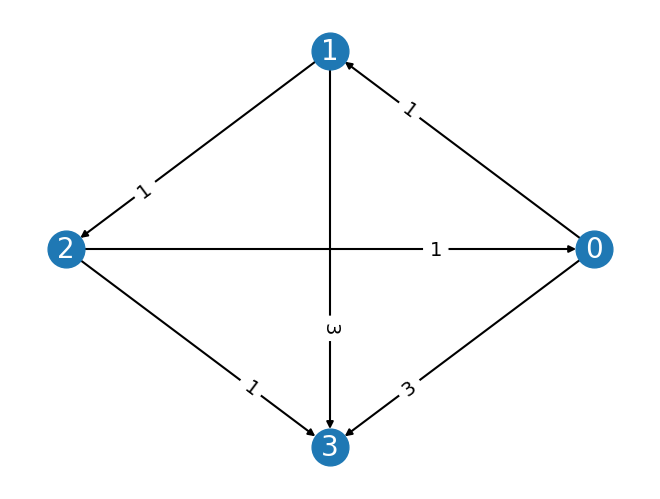

{0: 9, 1: 9, 2: 8, 3: 4}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [0, 1]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 2 | 3 | 0 | 0 |
| 1 | 2 | 3 | 1 |
| 0 | 0 | 2 | 3 |
| 3 | 1 | 1 | 2 |
+---+---+---+---+


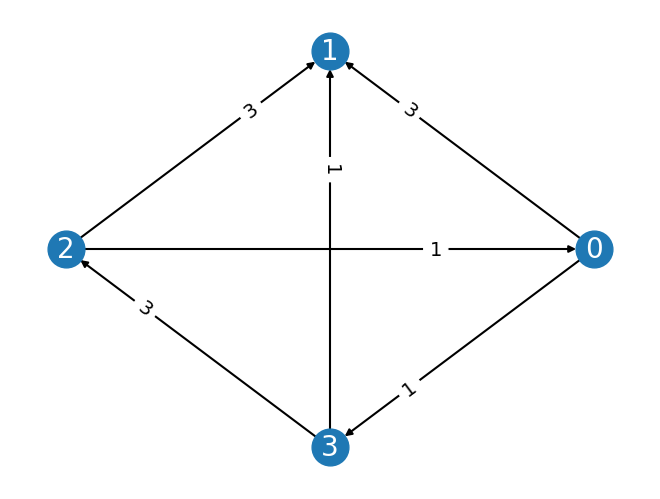

{0: 9, 1: 4, 2: 8, 3: 9}
c_ws [0, 2, 3]
c_b_ws [3]
c_gb_ws [0, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 2 | 3 | 1 | 1 |
| 3 | 0 | 1 | 3 | 0 |
| 0 | 3 | 0 | 0 | 2 |
| 1 | 1 | 2 | 2 | 3 |
+---+---+---+---+---+


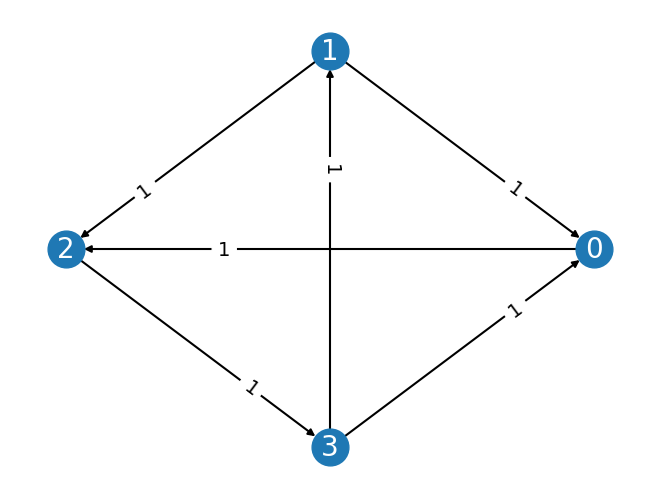

{0: 7, 1: 8, 2: 7, 3: 8}
c_ws [1, 3]
c_b_ws [3]
c_gb_ws [1, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 2 | 0 | 0 | 3 |
| 3 | 1 | 2 | 1 | 1 |
| 1 | 0 | 3 | 3 | 0 |
| 0 | 3 | 1 | 2 | 2 |
+---+---+---+---+---+


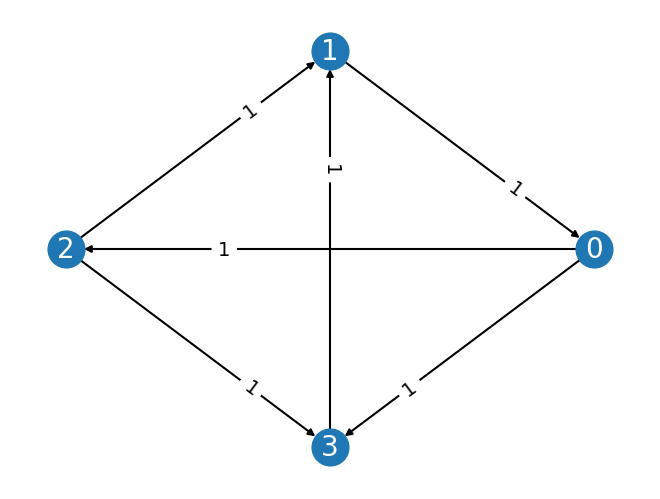

{0: 8, 1: 7, 2: 8, 3: 7}
c_ws [0, 2]
c_b_ws [0]
c_gb_ws [0, 2]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 0 | 2 | 3 |
| 3 | 1 | 0 | 0 |
| 2 | 2 | 3 | 2 |
| 0 | 3 | 1 | 1 |
+---+---+---+---+


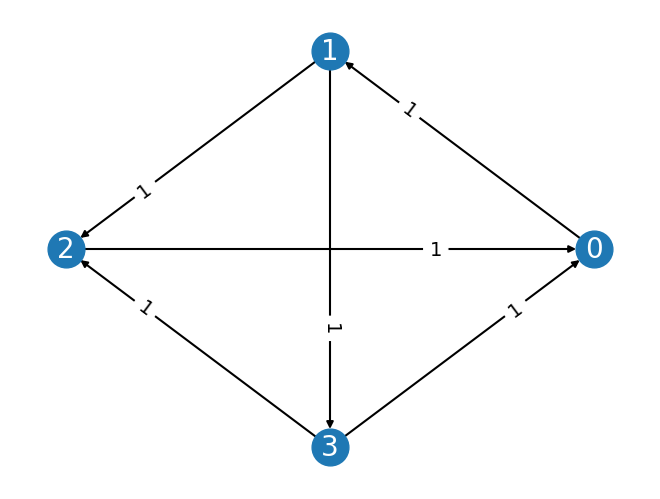

{0: 7, 1: 8, 2: 7, 3: 8}
c_ws [1, 3]
c_b_ws [1]
c_gb_ws [1, 3]
+---+---+---+---+
| 1 | 1 | 1 | 2 |
+---+---+---+---+
| 1 | 1 | 0 | 2 |
| 2 | 3 | 3 | 0 |
| 3 | 2 | 1 | 1 |
| 0 | 0 | 2 | 3 |
+---+---+---+---+


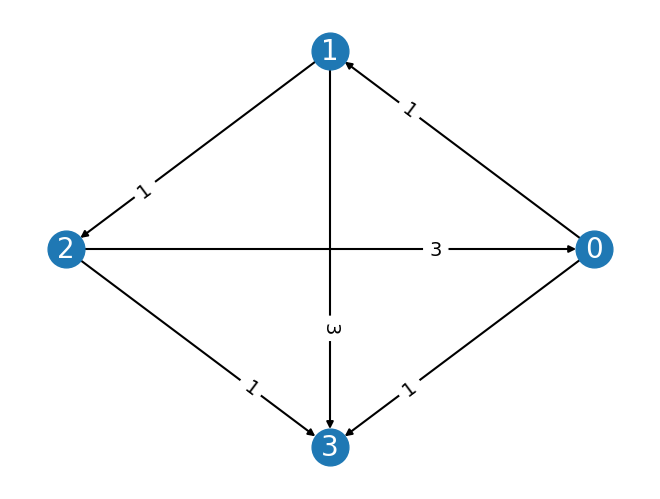

{0: 7, 1: 9, 2: 9, 3: 5}
c_ws [0, 1, 2]
c_b_ws [2]
c_gb_ws [1, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 2 | 1 | 1 | 3 |
| 2 | 3 | 2 | 2 | 1 |
| 1 | 1 | 3 | 0 | 0 |
| 0 | 0 | 0 | 3 | 2 |
+---+---+---+---+---+


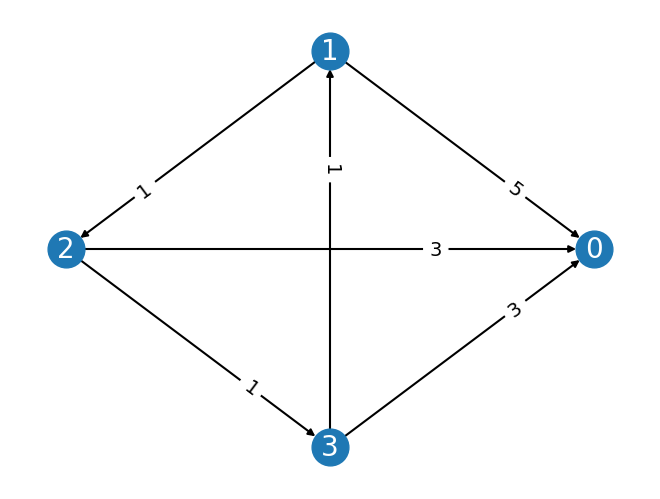

{0: 2, 1: 10, 2: 9, 3: 9}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 3 | 0 | 0 | 2 |
| 2 | 2 | 3 | 1 | 0 |
| 0 | 1 | 1 | 2 | 1 |
| 3 | 0 | 2 | 3 | 3 |
+---+---+---+---+---+


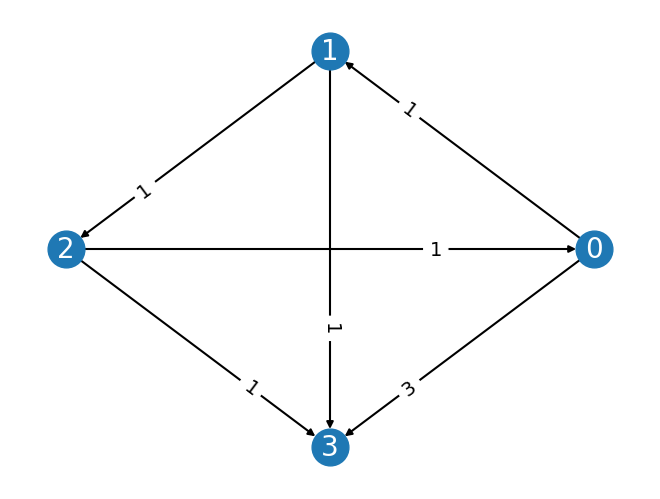

{0: 9, 1: 8, 2: 8, 3: 5}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [0]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 2 | 3 | 3 | 1 |
| 2 | 3 | 0 | 1 | 0 |
| 3 | 1 | 2 | 0 | 2 |
| 0 | 0 | 1 | 2 | 3 |
+---+---+---+---+---+


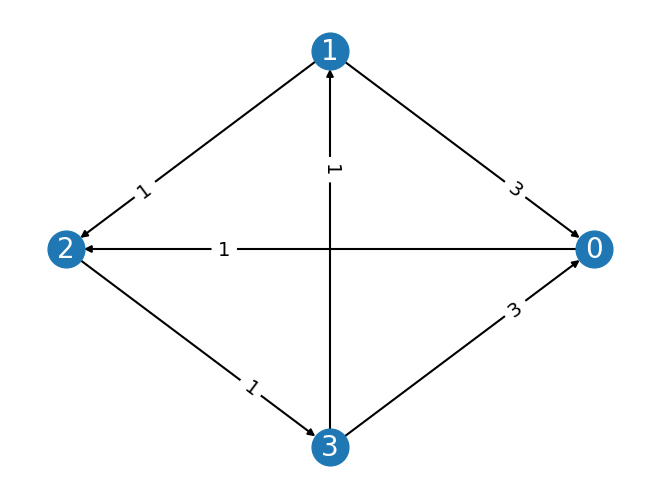

{0: 5, 1: 9, 2: 7, 3: 9}
c_ws [1, 3]
c_b_ws [3]
c_gb_ws [1, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 3 | 2 | 3 | 0 |
| 0 | 0 | 1 | 0 | 1 |
| 3 | 1 | 3 | 2 | 2 |
| 2 | 2 | 0 | 1 | 3 |
+---+---+---+---+---+


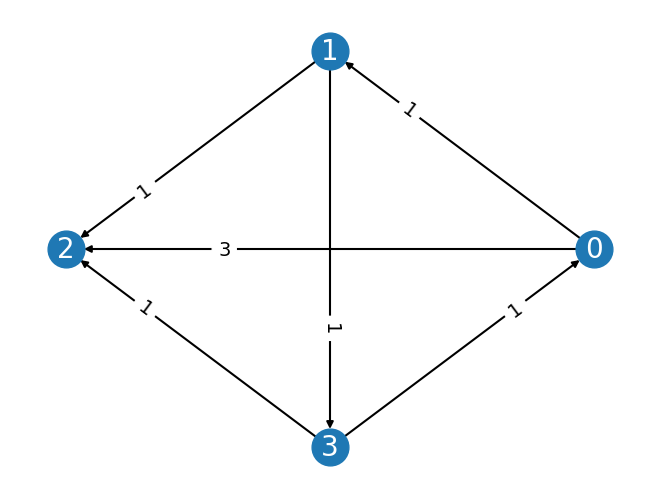

{0: 9, 1: 8, 2: 5, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 2 | 3 | 0 | 3 |
| 0 | 3 | 1 | 1 | 1 |
| 1 | 0 | 0 | 2 | 2 |
| 3 | 1 | 2 | 3 | 0 |
+---+---+---+---+---+


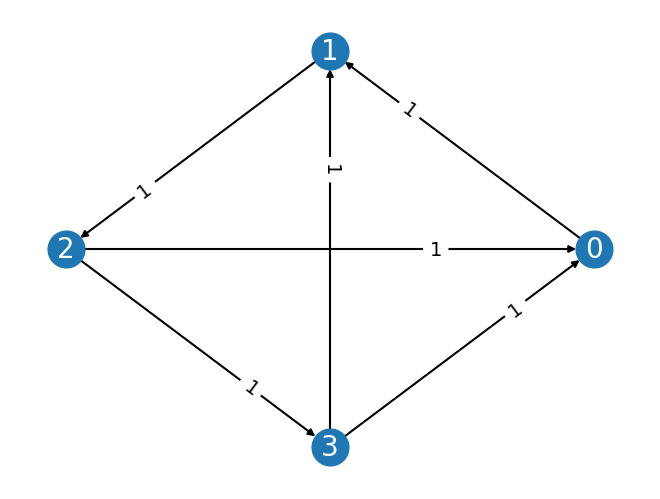

{0: 7, 1: 7, 2: 8, 3: 8}
c_ws [2, 3]
c_b_ws [2]
c_gb_ws [2, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 3 | 1 | 0 | 1 |
| 2 | 1 | 3 | 3 | 0 |
| 3 | 2 | 0 | 2 | 2 |
| 1 | 0 | 2 | 1 | 3 |
+---+---+---+---+---+


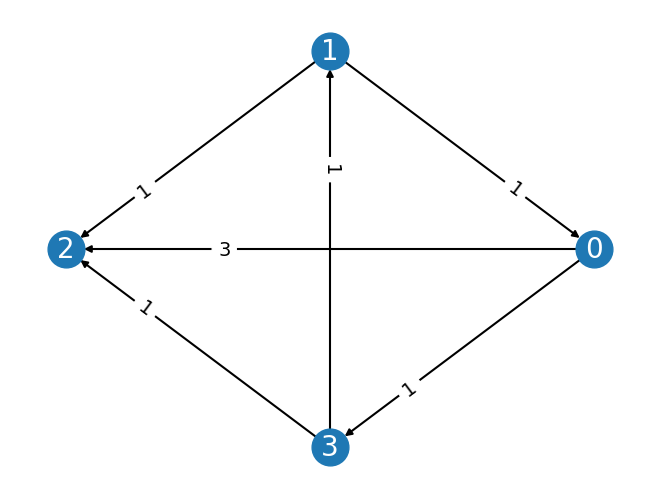

{0: 9, 1: 8, 2: 5, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 3 | 0 | 2 | 1 |
| 1 | 2 | 0 | 2 |
| 2 | 1 | 3 | 3 |
| 0 | 3 | 1 | 0 |
+---+---+---+---+


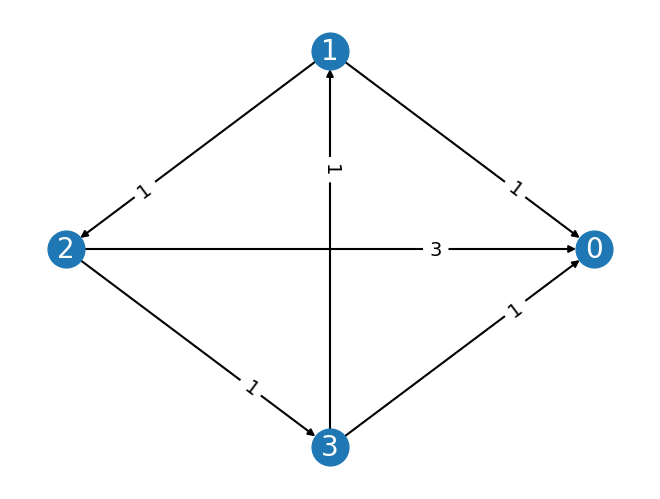

{0: 5, 1: 8, 2: 9, 3: 8}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [2]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 1 | 3 | 1 | 2 |
| 3 | 0 | 0 | 0 |
| 2 | 2 | 2 | 1 |
| 0 | 1 | 3 | 3 |
+---+---+---+---+


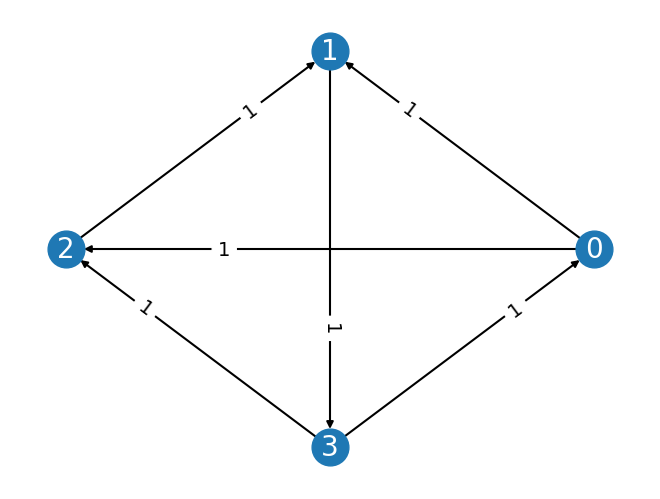

{0: 8, 1: 7, 2: 7, 3: 8}
c_ws [0, 3]
c_b_ws [3]
c_gb_ws [0, 3]
+---+---+---+---+
| 1 | 1 | 2 | 1 |
+---+---+---+---+
| 0 | 1 | 2 | 0 |
| 2 | 3 | 3 | 1 |
| 3 | 0 | 0 | 2 |
| 1 | 2 | 1 | 3 |
+---+---+---+---+


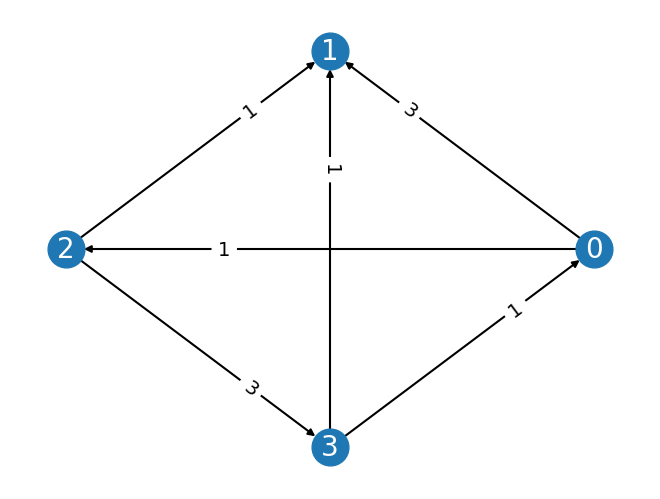

{0: 9, 1: 5, 2: 9, 3: 7}
c_ws [0, 2, 3]
c_b_ws [2]
c_gb_ws [0, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 2 | 3 | 1 | 1 |
| 1 | 0 | 2 | 0 | 2 |
| 2 | 1 | 0 | 3 | 3 |
| 3 | 3 | 1 | 2 | 0 |
+---+---+---+---+---+


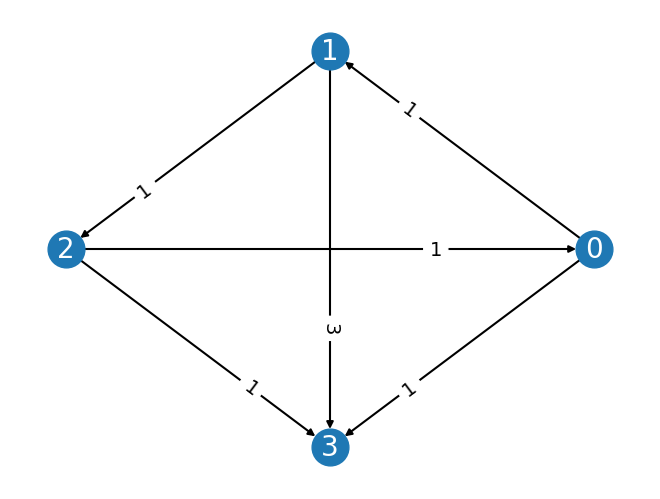

{0: 8, 1: 9, 2: 8, 3: 5}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 0 | 2 | 1 | 3 |
| 2 | 3 | 1 | 0 | 2 |
| 0 | 2 | 0 | 3 | 1 |
| 3 | 1 | 3 | 2 | 0 |
+---+---+---+---+---+


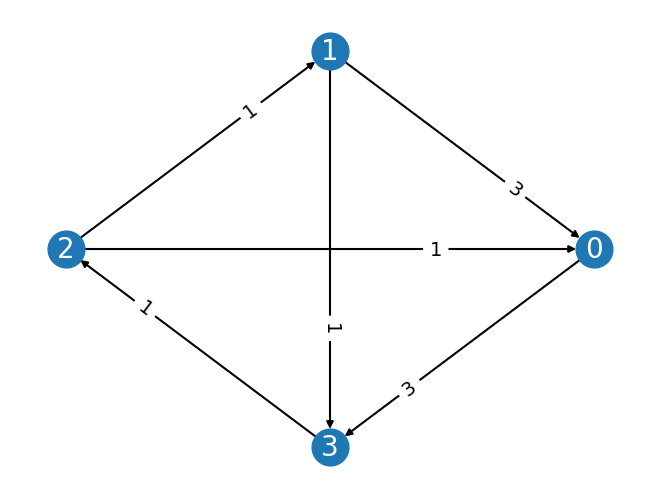

{0: 7, 1: 9, 2: 8, 3: 6}
c_ws [1, 2]
c_b_ws [2]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 2 | 1 | 2 | 1 |
| 1 | 3 | 2 | 0 | 0 |
| 2 | 1 | 0 | 3 | 3 |
| 0 | 0 | 3 | 1 | 2 |
+---+---+---+---+---+


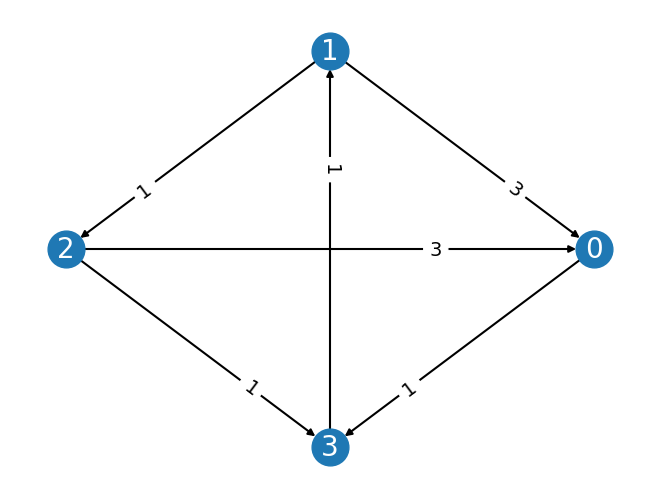

{0: 5, 1: 9, 2: 9, 3: 7}
c_ws [1, 2]
c_b_ws [1]
c_gb_ws [1, 2]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 2 | 0 | 1 | 3 |
| 1 | 2 | 3 | 0 |
| 3 | 3 | 0 | 1 |
| 0 | 1 | 2 | 2 |
+---+---+---+---+


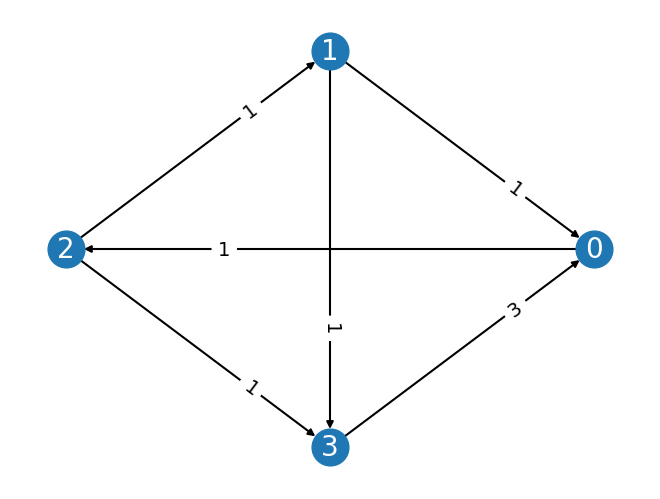

{0: 6, 1: 8, 2: 8, 3: 8}
c_ws [1, 2]
c_b_ws [2]
c_gb_ws [1, 2]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 0 | 3 | 0 |
| 2 | 3 | 2 | 1 |
| 3 | 2 | 0 | 2 |
| 0 | 1 | 1 | 3 |
+---+---+---+---+


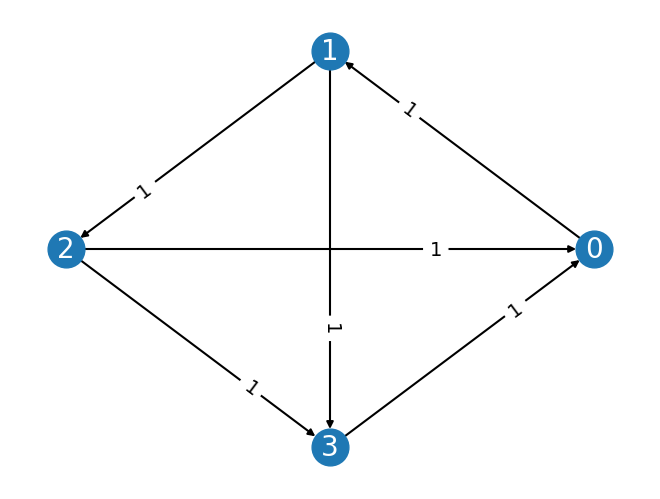

{0: 7, 1: 8, 2: 8, 3: 7}
c_ws [1, 2]
c_b_ws [1]
c_gb_ws [1, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 0 | 3 | 2 | 1 |
| 2 | 3 | 2 | 0 | 2 |
| 1 | 1 | 0 | 3 | 0 |
| 0 | 2 | 1 | 1 | 3 |
+---+---+---+---+---+


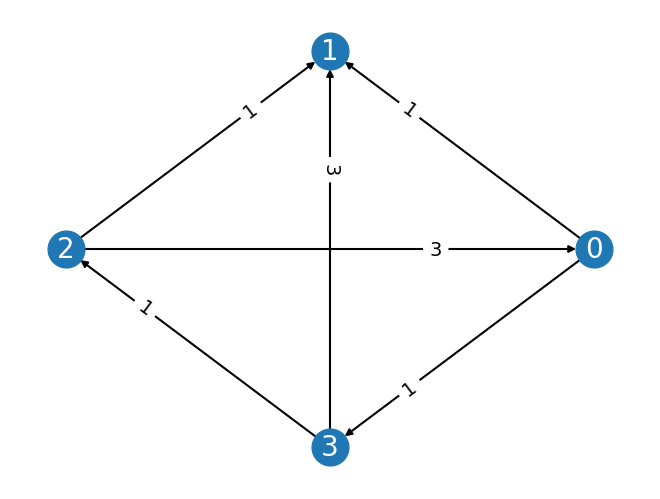

{0: 7, 1: 5, 2: 9, 3: 9}
c_ws [0, 2, 3]
c_b_ws [2]
c_gb_ws [2, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 2 | 3 | 1 | 2 |
| 0 | 3 | 0 | 0 | 1 |
| 1 | 1 | 2 | 2 | 3 |
| 2 | 0 | 1 | 3 | 0 |
+---+---+---+---+---+


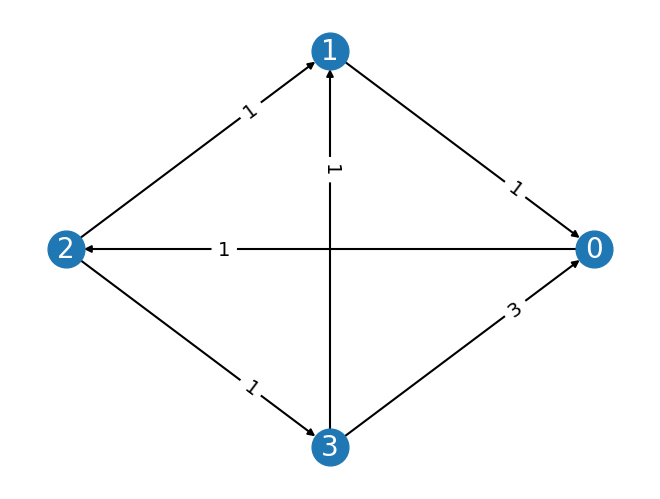

{0: 6, 1: 7, 2: 8, 3: 9}
c_ws [2, 3]
c_b_ws [2]
c_gb_ws [3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 0 | 1 | 3 | 0 |
| 2 | 2 | 0 | 1 | 1 |
| 1 | 3 | 2 | 0 | 2 |
| 0 | 1 | 3 | 2 | 3 |
+---+---+---+---+---+


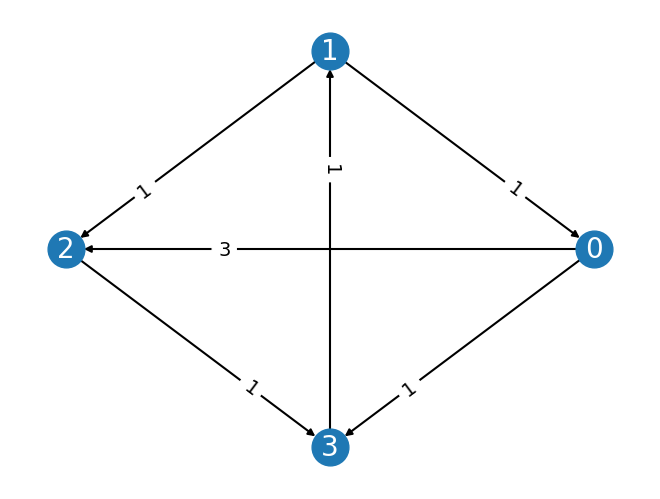

{0: 9, 1: 8, 2: 6, 3: 7}
c_ws [0, 1]
c_b_ws [1]
c_gb_ws [0]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 2 | 1 | 3 | 0 |
| 1 | 3 | 2 | 3 |
| 0 | 0 | 1 | 1 |
| 3 | 2 | 0 | 2 |
+---+---+---+---+


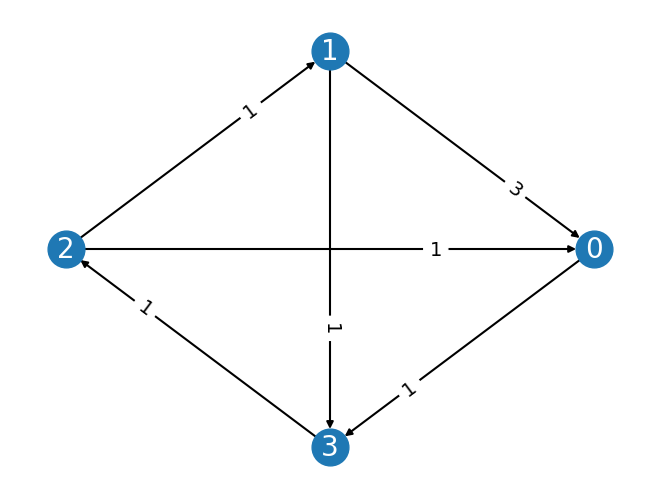

{0: 6, 1: 9, 2: 8, 3: 7}
c_ws [1, 2]
c_b_ws [2]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 2 | 0 | 0 | 1 |
| 2 | 3 | 1 | 3 | 0 |
| 1 | 1 | 3 | 2 | 3 |
| 0 | 0 | 2 | 1 | 2 |
+---+---+---+---+---+


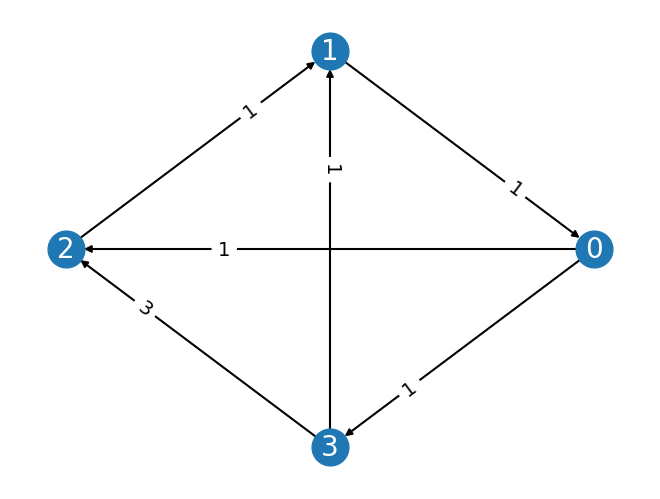

{0: 8, 1: 7, 2: 6, 3: 9}
c_ws [0, 3]
c_b_ws [0]
c_gb_ws [3]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 3 | 1 | 2 | 0 |
| 2 | 2 | 0 | 3 |
| 1 | 0 | 3 | 1 |
| 0 | 3 | 1 | 2 |
+---+---+---+---+


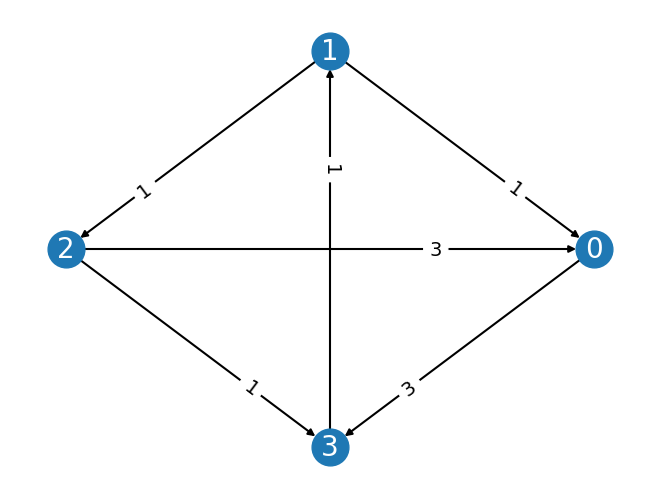

{0: 7, 1: 8, 2: 9, 3: 6}
c_ws [1, 2]
c_b_ws [1]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 1 | 3 | 0 | 2 |
| 0 | 2 | 2 | 3 | 3 |
| 2 | 3 | 1 | 1 | 1 |
| 3 | 0 | 0 | 2 | 0 |
+---+---+---+---+---+


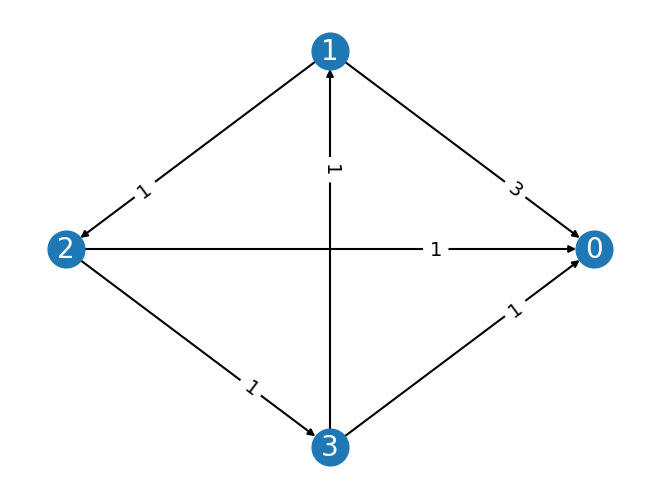

{0: 5, 1: 9, 2: 8, 3: 8}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 0 | 1 | 1 | 2 |
| 2 | 2 | 3 | 0 | 1 |
| 0 | 3 | 0 | 3 | 3 |
| 1 | 1 | 2 | 2 | 0 |
+---+---+---+---+---+


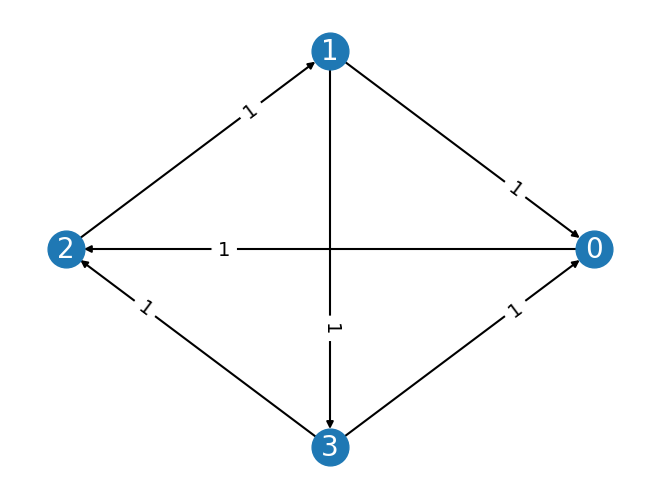

{0: 7, 1: 8, 2: 7, 3: 8}
c_ws [1, 3]
c_b_ws [1]
c_gb_ws [1, 3]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 2 | 0 | 3 | 2 |
| 0 | 3 | 2 | 1 |
| 1 | 2 | 1 | 0 |
| 3 | 1 | 0 | 3 |
+---+---+---+---+


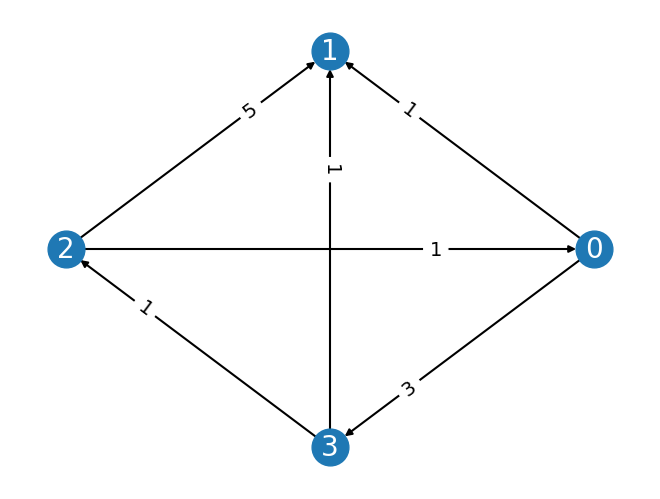

{0: 9, 1: 4, 2: 10, 3: 7}
c_ws [0, 2, 3]
c_b_ws [0]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 2 | 0 | 3 | 2 |
| 3 | 0 | 3 | 1 | 1 |
| 2 | 3 | 1 | 2 | 3 |
| 1 | 1 | 2 | 0 | 0 |
+---+---+---+---+---+


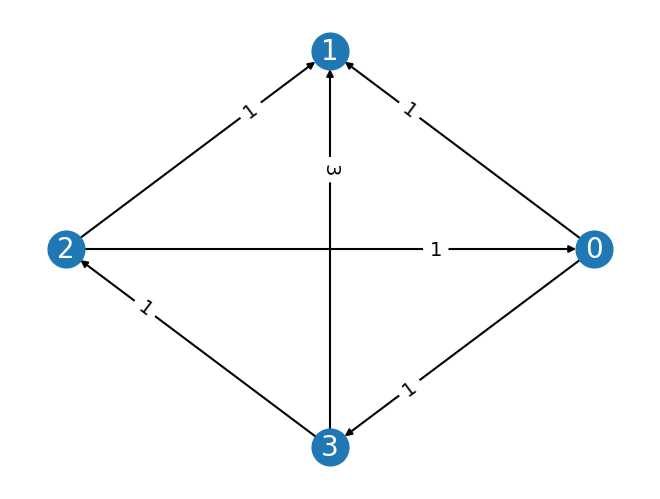

{0: 8, 1: 5, 2: 8, 3: 9}
c_ws [0, 2, 3]
c_b_ws [0, 2, 3]
c_gb_ws [3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 1 | 2 | 3 | 3 |
| 0 | 3 | 1 | 0 | 1 |
| 1 | 0 | 3 | 2 | 2 |
| 3 | 2 | 0 | 1 | 0 |
+---+---+---+---+---+


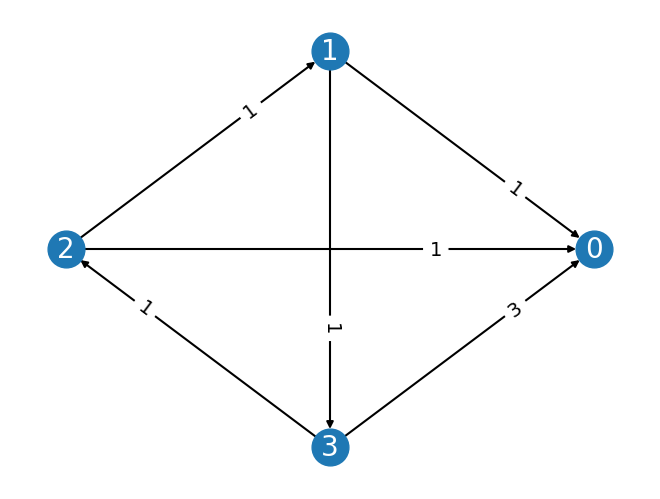

{0: 5, 1: 8, 2: 8, 3: 9}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [3]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 1 | 2 | 1 | 0 |
| 2 | 3 | 2 | 1 |
| 0 | 0 | 3 | 2 |
| 3 | 1 | 0 | 3 |
+---+---+---+---+


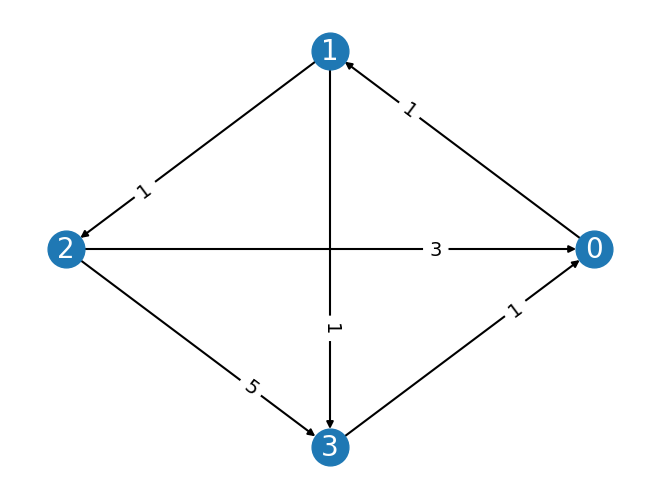

{0: 6, 1: 8, 2: 11, 3: 5}
c_ws [1, 2]
c_b_ws [1]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 3 | 0 | 0 | 1 |
| 1 | 2 | 2 | 3 | 0 |
| 0 | 1 | 1 | 1 | 2 |
| 2 | 0 | 3 | 2 | 3 |
+---+---+---+---+---+


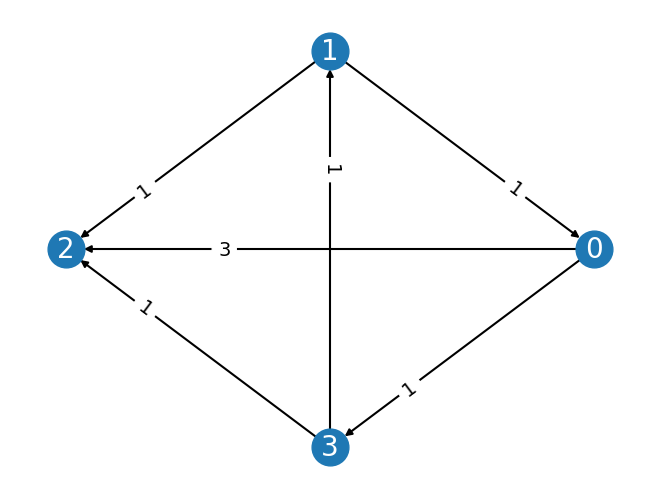

{0: 9, 1: 8, 2: 5, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 1 | 1 | 2 | 3 |
| 2 | 2 | 3 | 1 | 2 |
| 0 | 0 | 2 | 0 | 1 |
| 1 | 3 | 0 | 3 | 0 |
+---+---+---+---+---+


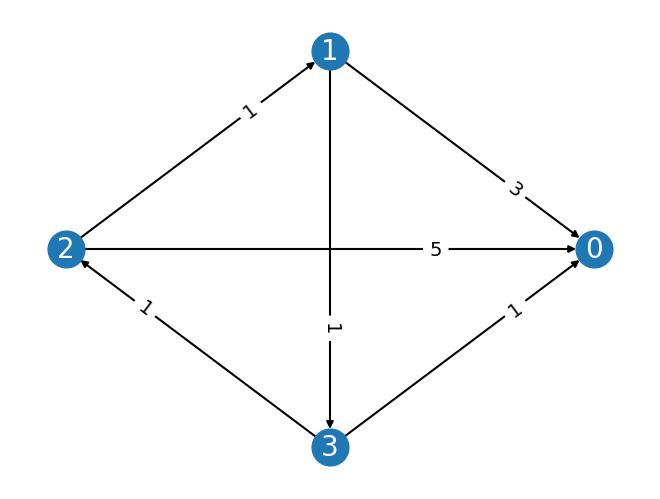

{0: 3, 1: 9, 2: 10, 3: 8}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 0 | 3 | 2 | 3 |
| 2 | 1 | 0 | 0 | 0 |
| 3 | 2 | 1 | 3 | 2 |
| 0 | 3 | 2 | 1 | 1 |
+---+---+---+---+---+


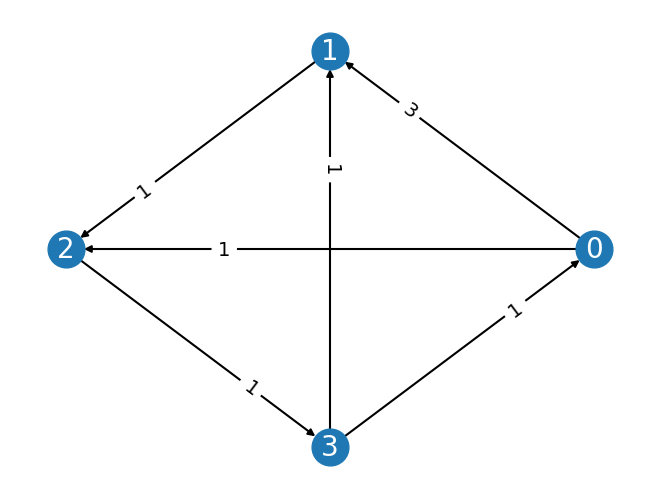

{0: 9, 1: 6, 2: 7, 3: 8}
c_ws [0, 3]
c_b_ws [3]
c_gb_ws [0]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 1 | 3 | 2 |
| 3 | 0 | 3 | 1 | 0 |
| 1 | 3 | 0 | 2 | 3 |
| 2 | 2 | 2 | 0 | 1 |
+---+---+---+---+---+


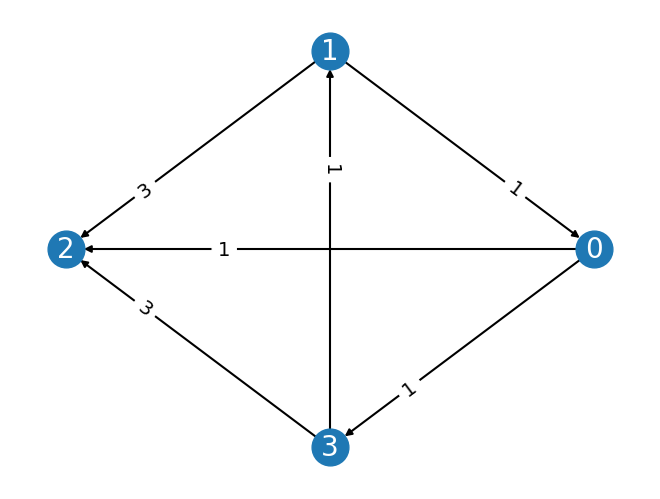

{0: 8, 1: 9, 2: 4, 3: 9}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [1, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 2 | 0 | 3 | 0 |
| 2 | 1 | 3 | 2 | 1 |
| 0 | 0 | 2 | 0 | 3 |
| 3 | 3 | 1 | 1 | 2 |
+---+---+---+---+---+


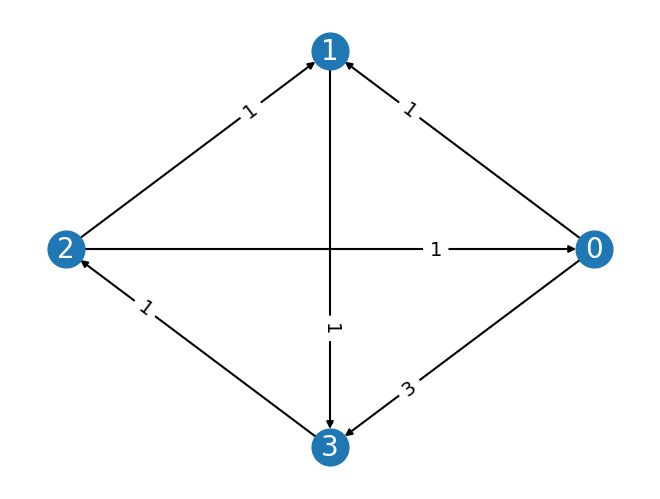

{0: 9, 1: 7, 2: 8, 3: 6}
c_ws [0, 2]
c_b_ws [2]
c_gb_ws [0]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 0 | 3 | 2 | 2 |
| 2 | 3 | 0 | 3 | 1 |
| 3 | 1 | 1 | 1 | 3 |
| 1 | 2 | 2 | 0 | 0 |
+---+---+---+---+---+


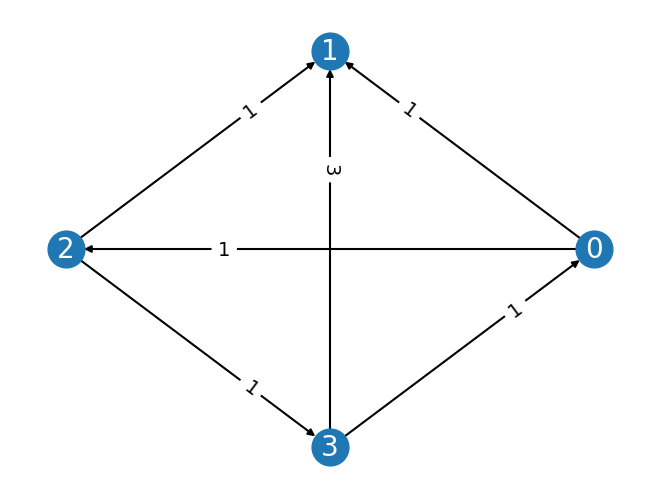

{0: 8, 1: 5, 2: 8, 3: 9}
c_ws [0, 2, 3]
c_b_ws [0, 2, 3]
c_gb_ws [3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 2 | 2 | 3 | 0 |
| 2 | 3 | 1 | 0 | 1 |
| 1 | 1 | 3 | 2 | 2 |
| 3 | 0 | 0 | 1 | 3 |
+---+---+---+---+---+


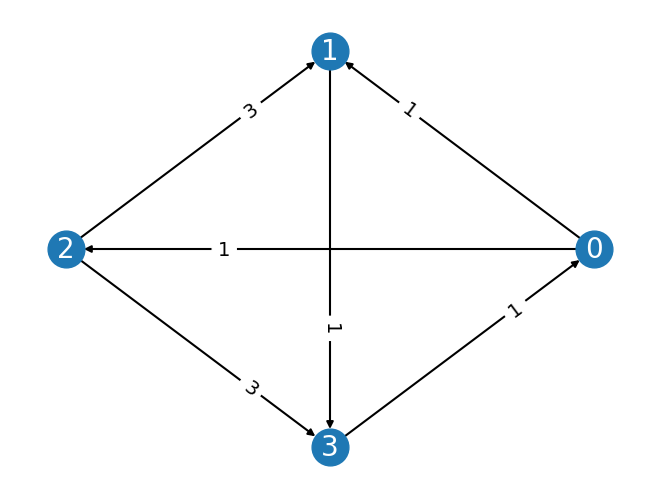

{0: 8, 1: 6, 2: 10, 3: 6}
c_ws [0, 2]
c_b_ws [0]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 0 | 3 | 0 | 3 |
| 3 | 2 | 2 | 2 | 1 |
| 1 | 3 | 0 | 1 | 0 |
| 0 | 1 | 1 | 3 | 2 |
+---+---+---+---+---+


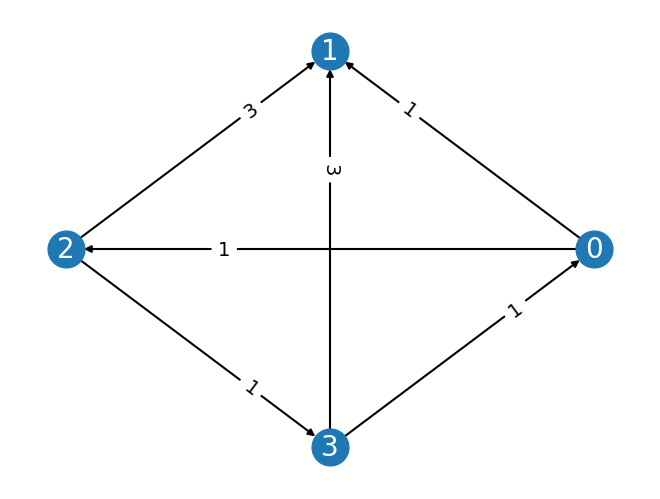

{0: 8, 1: 4, 2: 9, 3: 9}
c_ws [0, 2, 3]
c_b_ws [0, 2, 3]
c_gb_ws [2, 3]
+---+---+---+---+
| 1 | 1 | 2 | 1 |
+---+---+---+---+
| 0 | 1 | 3 | 1 |
| 1 | 0 | 0 | 2 |
| 2 | 3 | 2 | 3 |
| 3 | 2 | 1 | 0 |
+---+---+---+---+


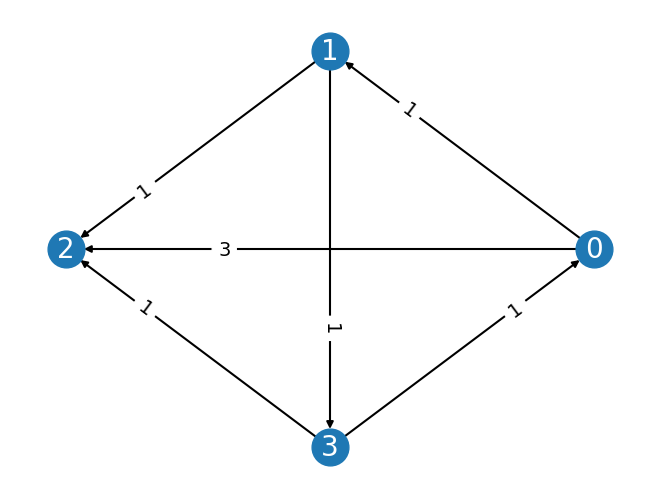

{0: 9, 1: 8, 2: 5, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 2 | 0 | 3 | 1 |
| 0 | 1 | 1 | 3 |
| 1 | 3 | 0 | 2 |
| 3 | 2 | 2 | 0 |
+---+---+---+---+


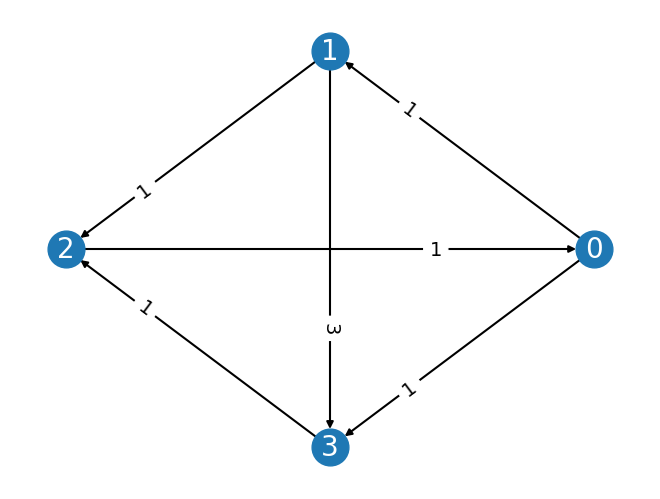

{0: 8, 1: 9, 2: 7, 3: 6}
c_ws [0, 1]
c_b_ws [0]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 3 | 3 | 2 | 2 |
| 1 | 0 | 2 | 0 | 0 |
| 3 | 1 | 0 | 1 | 3 |
| 2 | 2 | 1 | 3 | 1 |
+---+---+---+---+---+


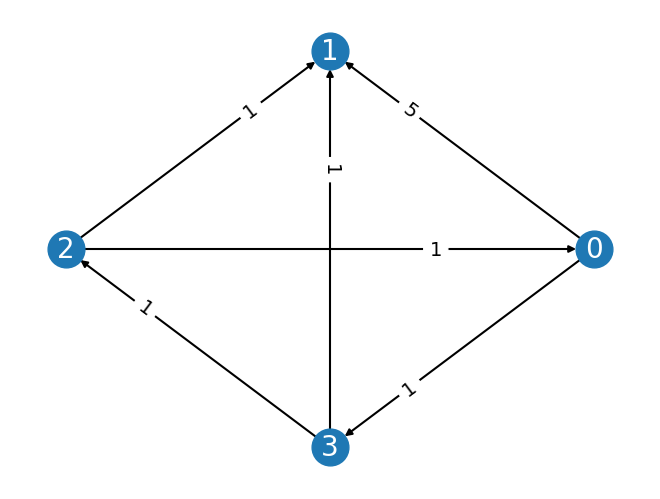

{0: 10, 1: 4, 2: 8, 3: 8}
c_ws [0, 2, 3]
c_b_ws [0, 2, 3]
c_gb_ws [0]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 0 | 1 | 2 |
| 1 | 2 | 3 | 3 | 0 |
| 3 | 0 | 1 | 2 | 1 |
| 2 | 3 | 2 | 0 | 3 |
+---+---+---+---+---+


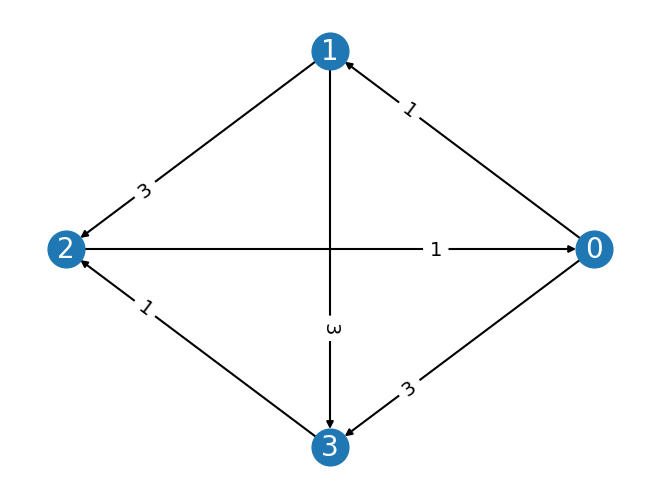

{0: 9, 1: 10, 2: 6, 3: 5}
c_ws [0, 1]
c_b_ws [0]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 0 | 2 | 1 | 3 |
| 1 | 2 | 3 | 3 | 1 |
| 2 | 3 | 0 | 0 | 2 |
| 3 | 1 | 1 | 2 | 0 |
+---+---+---+---+---+


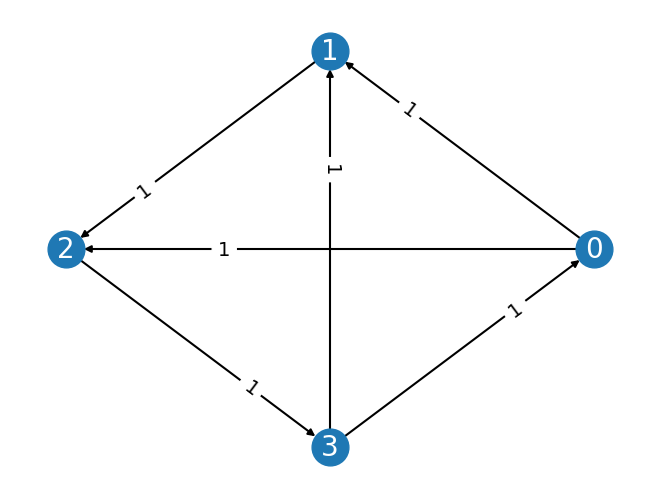

{0: 8, 1: 7, 2: 7, 3: 8}
c_ws [0, 3]
c_b_ws [3]
c_gb_ws [0, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 2 | 2 | 3 | 1 |
| 1 | 1 | 3 | 0 | 3 |
| 3 | 0 | 0 | 1 | 2 |
| 2 | 3 | 1 | 2 | 0 |
+---+---+---+---+---+


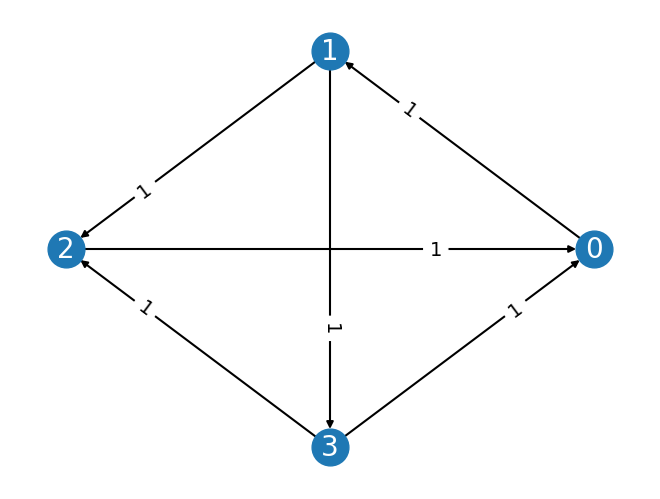

{0: 7, 1: 8, 2: 7, 3: 8}
c_ws [1, 3]
c_b_ws [1]
c_gb_ws [1, 3]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 2 | 3 | 0 | 1 |
| 1 | 2 | 1 | 0 |
| 0 | 0 | 3 | 3 |
| 3 | 1 | 2 | 2 |
+---+---+---+---+


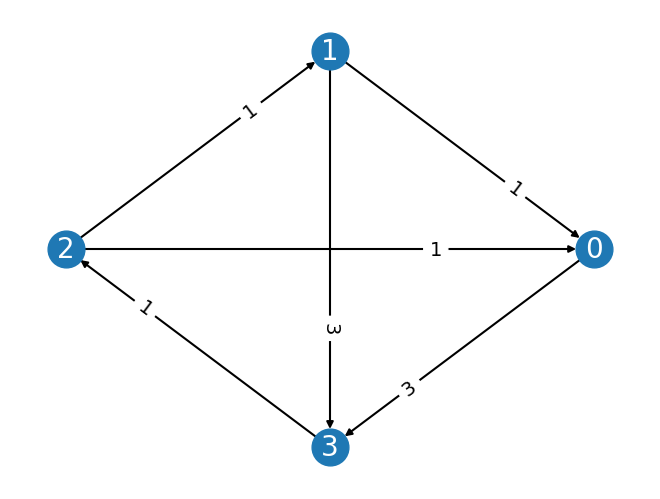

{0: 8, 1: 9, 2: 8, 3: 5}
c_ws [1, 2]
c_b_ws [2]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 1 | 2 | 3 | 0 |
| 0 | 3 | 1 | 2 | 1 |
| 3 | 0 | 0 | 1 | 3 |
| 1 | 2 | 3 | 0 | 2 |
+---+---+---+---+---+


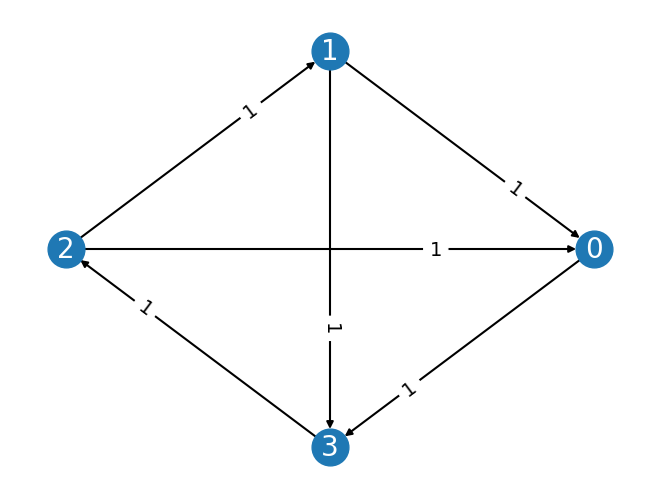

{0: 7, 1: 8, 2: 8, 3: 7}
c_ws [1, 2]
c_b_ws [2]
c_gb_ws [1, 2]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 3 | 2 | 1 | 2 |
| 2 | 1 | 3 | 0 |
| 0 | 0 | 2 | 1 |
| 1 | 3 | 0 | 3 |
+---+---+---+---+


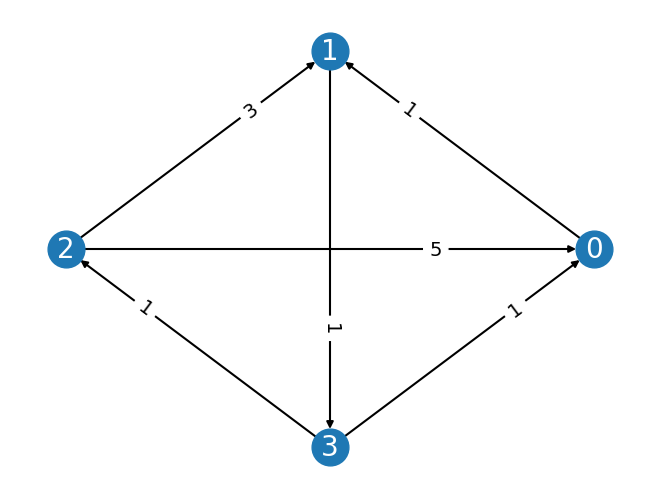

{0: 5, 1: 6, 2: 11, 3: 8}
c_ws [2, 3]
c_b_ws [3]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 0 | 1 | 3 | 1 |
| 0 | 2 | 0 | 2 | 2 |
| 2 | 3 | 2 | 1 | 0 |
| 1 | 1 | 3 | 0 | 3 |
+---+---+---+---+---+


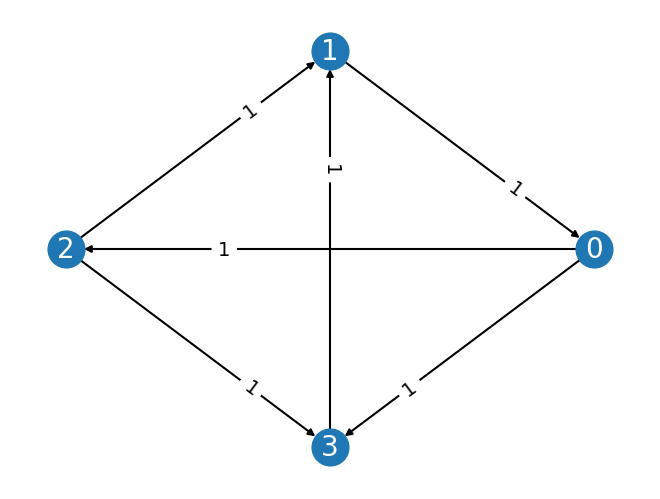

{0: 8, 1: 7, 2: 8, 3: 7}
c_ws [0, 2]
c_b_ws [0]
c_gb_ws [0, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 3 | 1 | 0 | 2 |
| 1 | 0 | 3 | 1 | 3 |
| 2 | 1 | 0 | 3 | 1 |
| 3 | 2 | 2 | 2 | 0 |
+---+---+---+---+---+


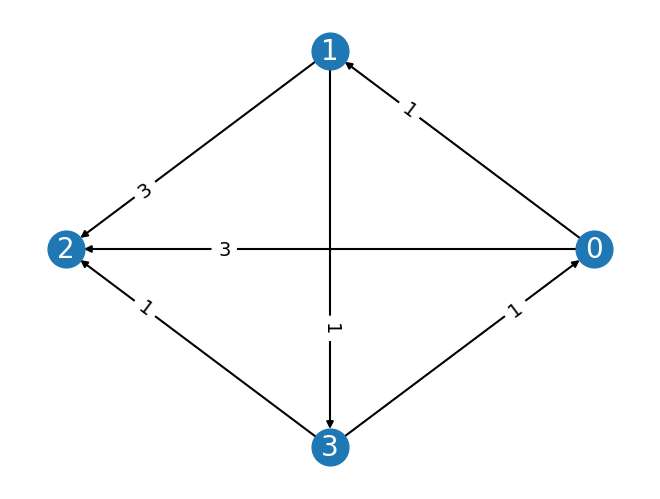

{0: 9, 1: 9, 2: 4, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0, 1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 3 | 1 | 2 | 0 |
| 3 | 2 | 2 | 0 | 1 |
| 2 | 0 | 3 | 1 | 2 |
| 0 | 1 | 0 | 3 | 3 |
+---+---+---+---+---+


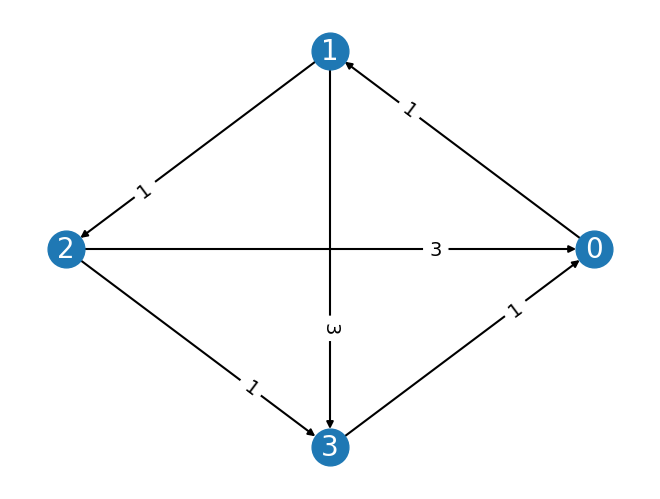

{0: 6, 1: 9, 2: 9, 3: 6}
c_ws [1, 2]
c_b_ws [1]
c_gb_ws [1, 2]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 3 | 0 | 1 | 1 |
| 2 | 2 | 2 | 0 |
| 1 | 1 | 3 | 3 |
| 0 | 3 | 0 | 2 |
+---+---+---+---+


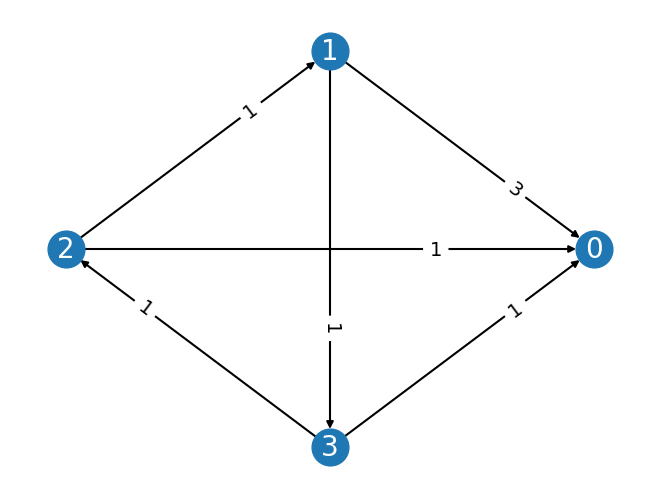

{0: 5, 1: 9, 2: 8, 3: 8}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [1]
+---+---+---+---+
| 1 | 1 | 2 | 1 |
+---+---+---+---+
| 2 | 2 | 3 | 1 |
| 3 | 1 | 1 | 2 |
| 0 | 0 | 0 | 0 |
| 1 | 3 | 2 | 3 |
+---+---+---+---+


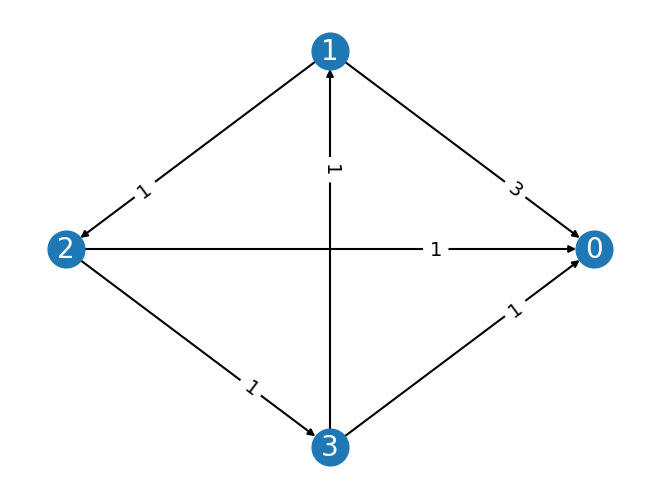

{0: 5, 1: 9, 2: 8, 3: 8}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 0 | 2 | 2 | 3 |
| 0 | 1 | 0 | 0 | 1 |
| 2 | 2 | 1 | 3 | 2 |
| 3 | 3 | 3 | 1 | 0 |
+---+---+---+---+---+


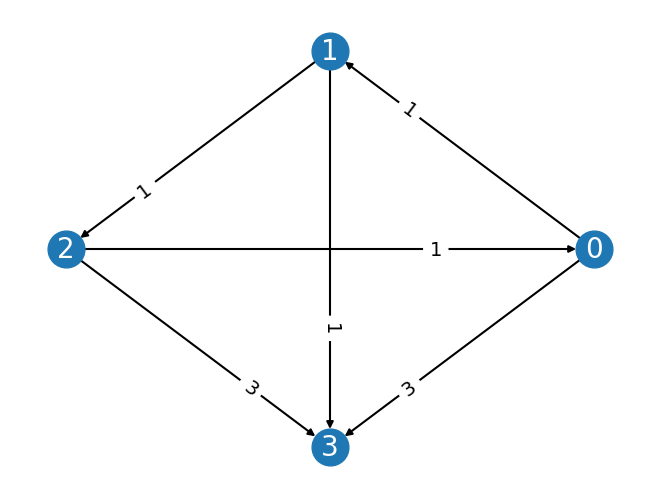

{0: 9, 1: 8, 2: 9, 3: 4}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [0, 2]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 3 | 2 | 2 | 1 |
| 0 | 1 | 0 | 3 |
| 2 | 3 | 1 | 2 |
| 1 | 0 | 3 | 0 |
+---+---+---+---+


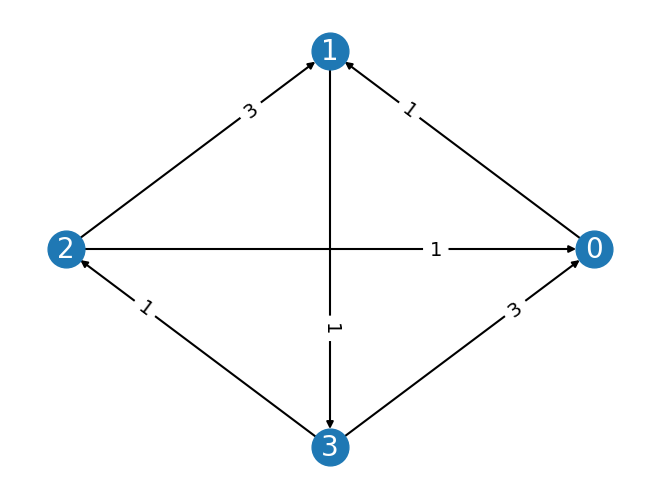

{0: 6, 1: 6, 2: 9, 3: 9}
c_ws [2, 3]
c_b_ws [3]
c_gb_ws [2, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 2 | 1 | 2 | 0 |
| 2 | 3 | 0 | 1 | 3 |
| 3 | 1 | 2 | 3 | 1 |
| 1 | 0 | 3 | 0 | 2 |
+---+---+---+---+---+


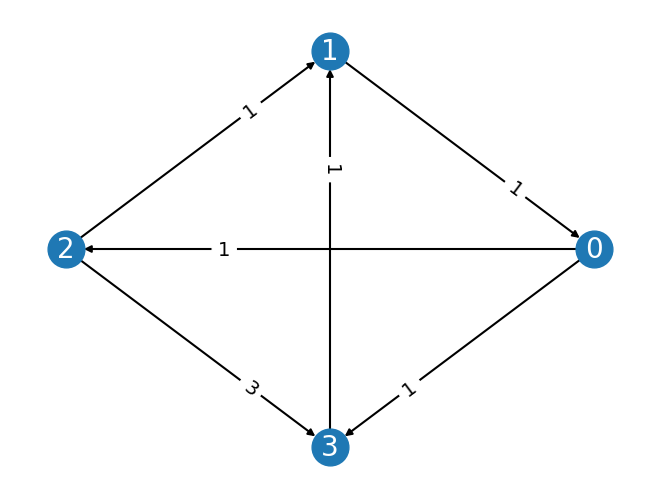

{0: 8, 1: 7, 2: 9, 3: 6}
c_ws [0, 2]
c_b_ws [0]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 3 | 2 | 2 | 0 |
| 0 | 2 | 3 | 0 | 3 |
| 3 | 0 | 1 | 3 | 2 |
| 2 | 1 | 0 | 1 | 1 |
+---+---+---+---+---+


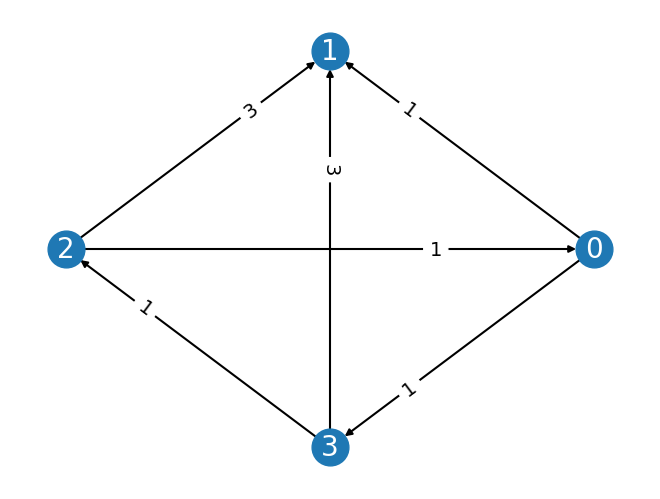

{0: 8, 1: 4, 2: 9, 3: 9}
c_ws [0, 2, 3]
c_b_ws [0, 2, 3]
c_gb_ws [2, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 2 | 0 | 0 | 3 |
| 0 | 1 | 2 | 2 | 2 |
| 3 | 0 | 3 | 1 | 1 |
| 2 | 3 | 1 | 3 | 0 |
+---+---+---+---+---+


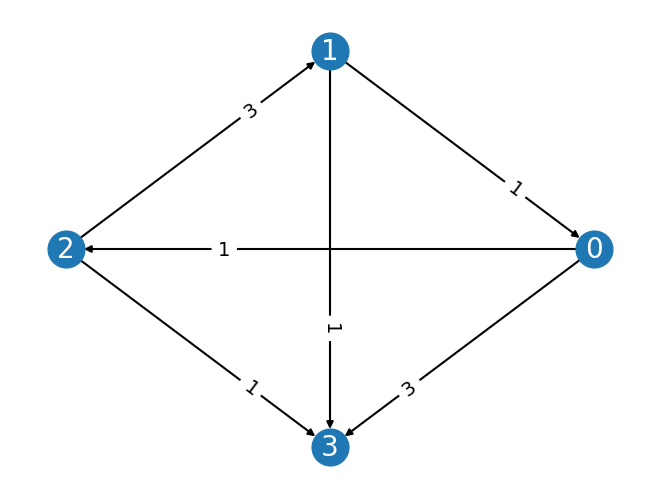

{0: 9, 1: 7, 2: 9, 3: 5}
c_ws [0, 1, 2]
c_b_ws [2]
c_gb_ws [0, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 2 | 0 | 1 | 1 |
| 3 | 1 | 3 | 3 | 3 |
| 1 | 0 | 2 | 2 | 0 |
| 0 | 3 | 1 | 0 | 2 |
+---+---+---+---+---+


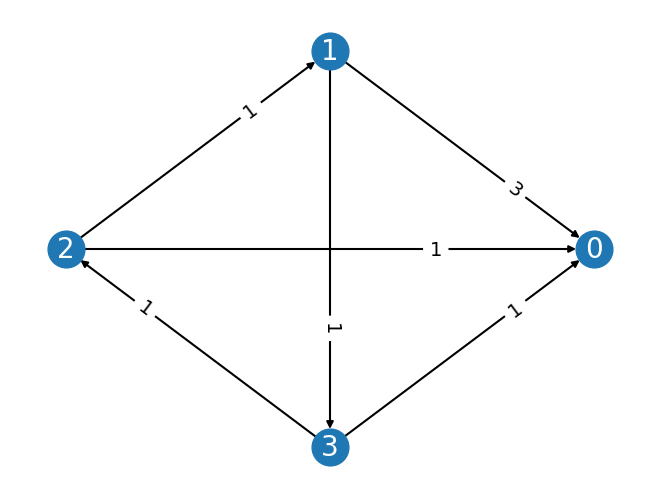

{0: 5, 1: 9, 2: 8, 3: 8}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 1 | 2 | 0 | 0 |
| 1 | 3 | 0 | 2 | 3 |
| 2 | 2 | 3 | 3 | 1 |
| 0 | 0 | 1 | 1 | 2 |
+---+---+---+---+---+


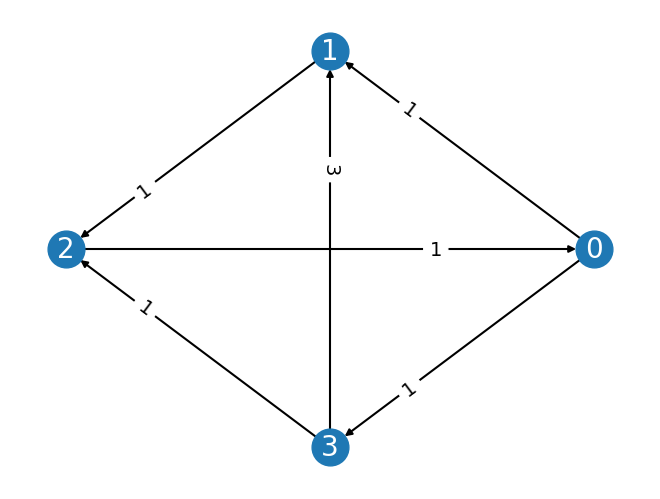

{0: 8, 1: 6, 2: 7, 3: 9}
c_ws [0, 3]
c_b_ws [0]
c_gb_ws [3]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 3 | 1 | 2 | 2 |
| 2 | 3 | 0 | 1 |
| 0 | 2 | 1 | 0 |
| 1 | 0 | 3 | 3 |
+---+---+---+---+


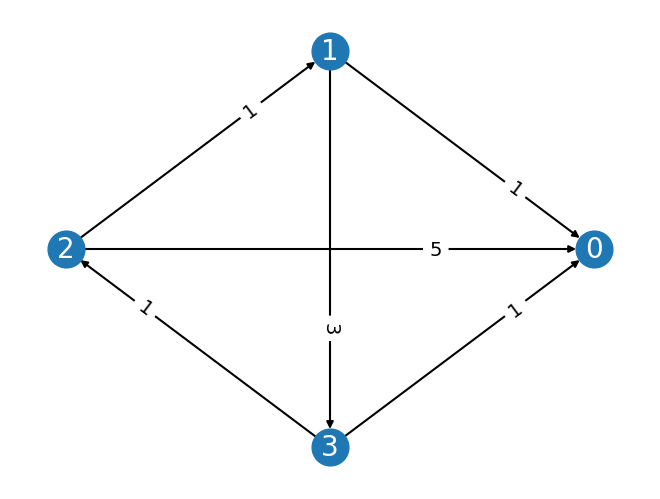

{0: 4, 1: 9, 2: 10, 3: 7}
c_ws [1, 2, 3]
c_b_ws [1]
c_gb_ws [2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 3 | 2 | 1 | 1 |
| 1 | 2 | 0 | 3 | 3 |
| 3 | 0 | 3 | 0 | 2 |
| 0 | 1 | 1 | 2 | 0 |
+---+---+---+---+---+


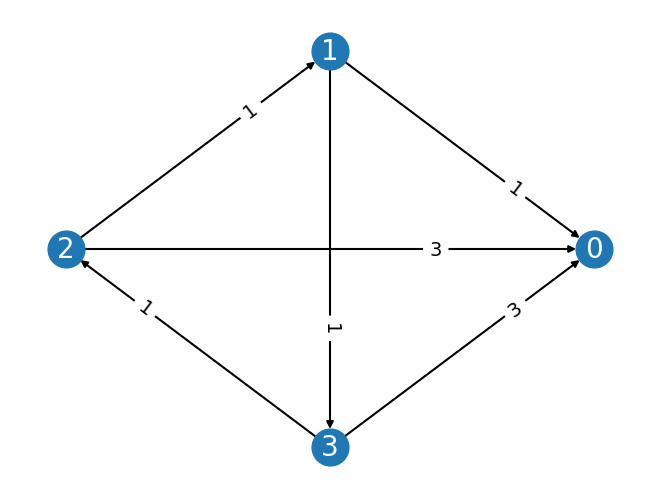

{0: 4, 1: 8, 2: 9, 3: 9}
c_ws [1, 2, 3]
c_b_ws [1, 2, 3]
c_gb_ws [2, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 3 | 3 | 1 |
| 3 | 2 | 0 | 2 | 0 |
| 1 | 0 | 1 | 1 | 3 |
| 2 | 3 | 2 | 0 | 2 |
+---+---+---+---+---+


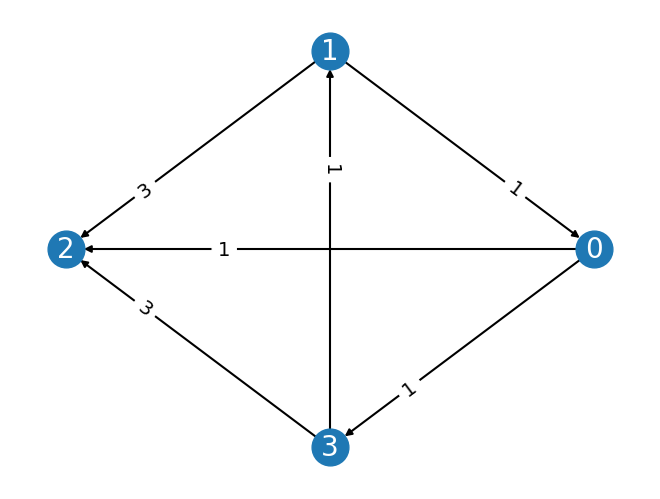

{0: 8, 1: 9, 2: 4, 3: 9}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [1, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 0 | 1 | 2 | 3 |
| 3 | 3 | 0 | 1 | 2 |
| 1 | 1 | 3 | 0 | 0 |
| 0 | 2 | 2 | 3 | 1 |
+---+---+---+---+---+


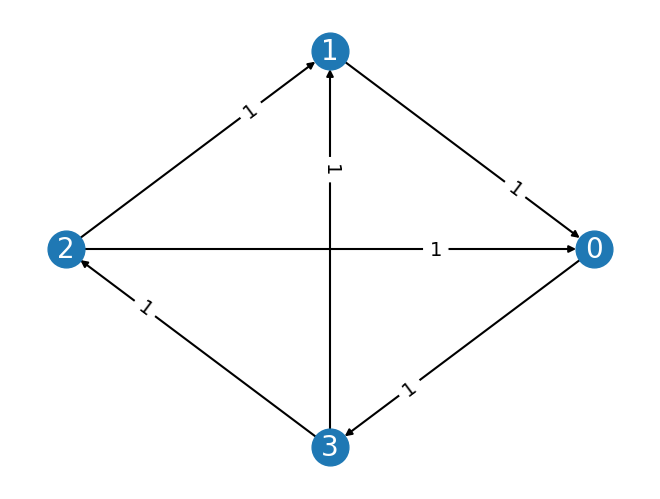

{0: 7, 1: 7, 2: 8, 3: 8}
c_ws [2, 3]
c_b_ws [3]
c_gb_ws [2, 3]
+---+---+---+---+
| 1 | 1 | 2 | 1 |
+---+---+---+---+
| 1 | 0 | 2 | 1 |
| 0 | 1 | 0 | 2 |
| 3 | 3 | 1 | 3 |
| 2 | 2 | 3 | 0 |
+---+---+---+---+


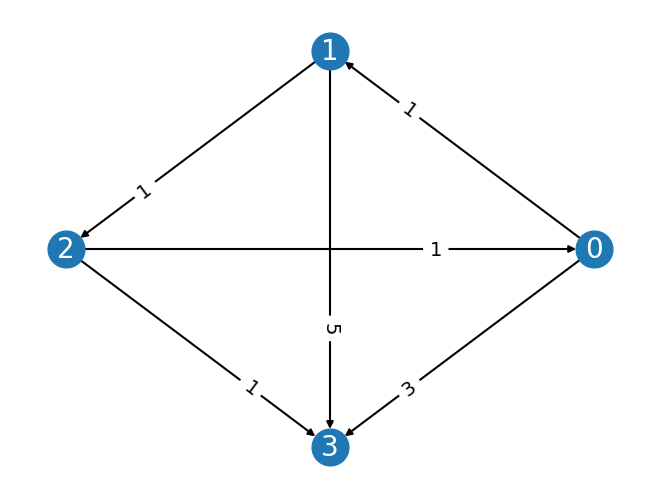

{0: 9, 1: 10, 2: 8, 3: 3}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 3 | 0 | 1 | 2 |
| 0 | 0 | 1 | 3 | 3 |
| 3 | 2 | 3 | 0 | 0 |
| 2 | 1 | 2 | 2 | 1 |
+---+---+---+---+---+


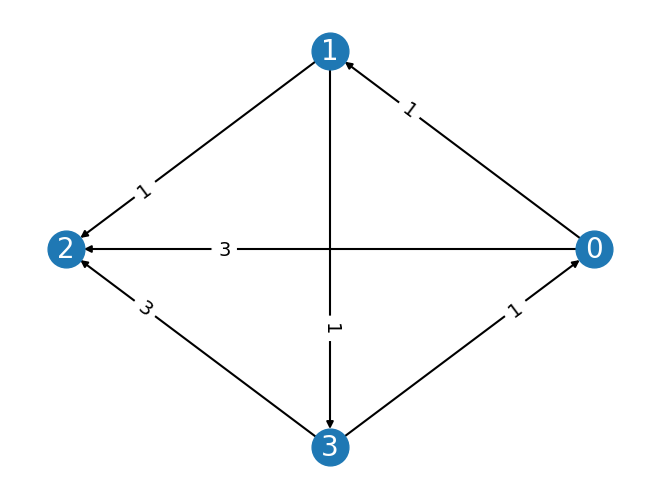

{0: 9, 1: 8, 2: 4, 3: 9}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0, 3]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 2 | 2 | 0 |
| 3 | 1 | 0 | 3 |
| 2 | 0 | 1 | 2 |
| 0 | 3 | 3 | 1 |
+---+---+---+---+


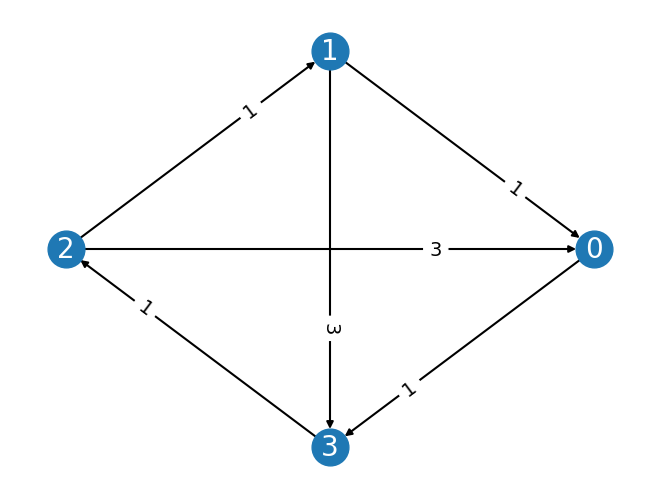

{0: 6, 1: 9, 2: 9, 3: 6}
c_ws [1, 2]
c_b_ws [2]
c_gb_ws [1, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 3 | 2 | 2 | 0 |
| 1 | 0 | 3 | 1 | 1 |
| 2 | 1 | 0 | 3 | 2 |
| 0 | 2 | 1 | 0 | 3 |
+---+---+---+---+---+


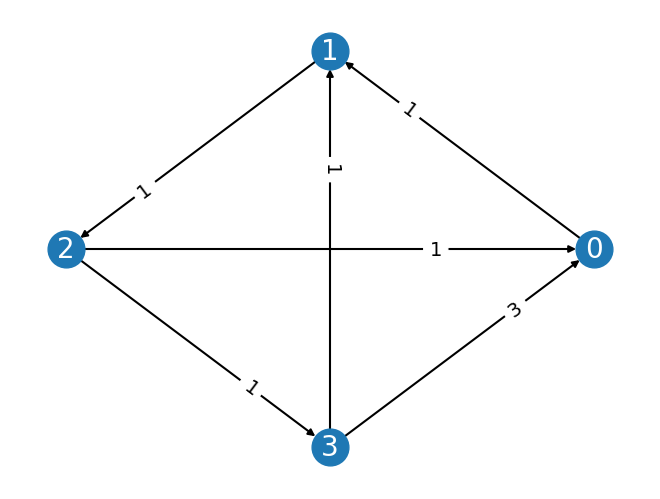

{0: 6, 1: 7, 2: 8, 3: 9}
c_ws [2, 3]
c_b_ws [2]
c_gb_ws [3]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 1 | 2 | 3 | 3 |
| 2 | 3 | 0 | 1 |
| 0 | 0 | 1 | 0 |
| 3 | 1 | 2 | 2 |
+---+---+---+---+


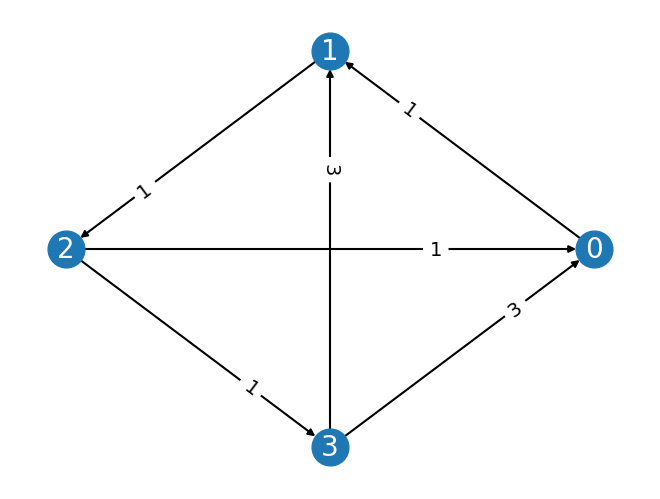

{0: 6, 1: 6, 2: 8, 3: 10}
c_ws [2, 3]
c_b_ws [2]
c_gb_ws [3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 3 | 2 | 0 |
| 3 | 3 | 2 | 0 | 1 |
| 1 | 2 | 0 | 3 | 3 |
| 2 | 0 | 1 | 1 | 2 |
+---+---+---+---+---+


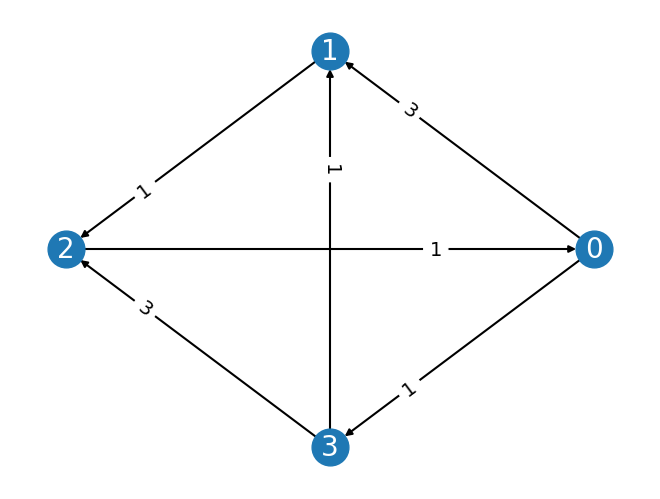

{0: 9, 1: 6, 2: 6, 3: 9}
c_ws [0, 3]
c_b_ws [0]
c_gb_ws [0, 3]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 3 | 1 | 1 | 2 | 2 |
| 0 | 3 | 0 | 0 | 0 |
| 1 | 2 | 3 | 3 | 1 |
| 2 | 0 | 2 | 1 | 3 |
+---+---+---+---+---+


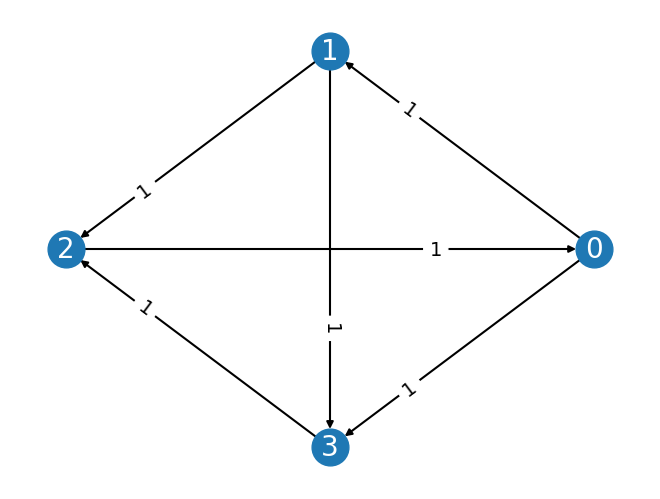

{0: 8, 1: 8, 2: 7, 3: 7}
c_ws [0, 1]
c_b_ws [0]
c_gb_ws [0, 1]
+---+---+---+---+
| 1 | 2 | 1 | 1 |
+---+---+---+---+
| 2 | 0 | 1 | 2 |
| 1 | 1 | 3 | 3 |
| 0 | 2 | 2 | 0 |
| 3 | 3 | 0 | 1 |
+---+---+---+---+


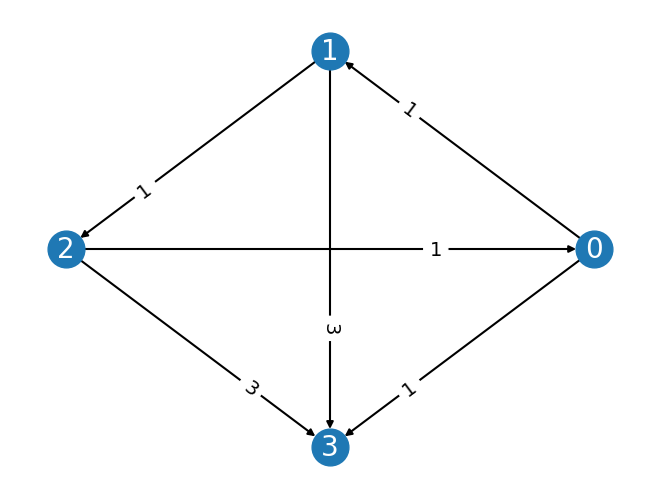

{0: 8, 1: 9, 2: 9, 3: 4}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [1, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 1 | 0 | 0 | 1 | 3 |
| 3 | 1 | 3 | 2 | 0 |
| 0 | 2 | 2 | 3 | 2 |
| 2 | 3 | 1 | 0 | 1 |
+---+---+---+---+---+


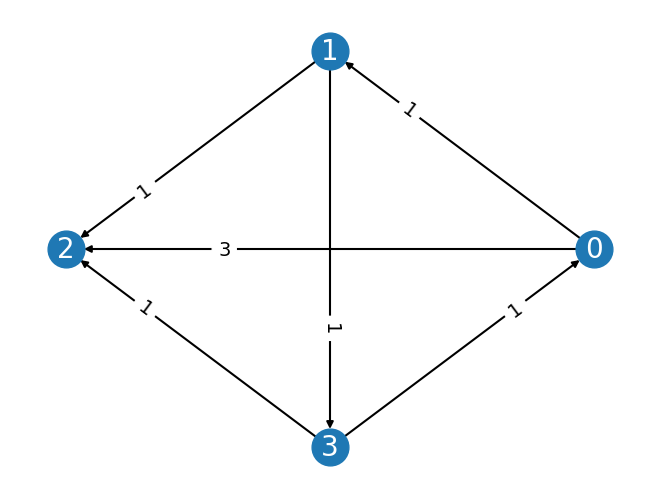

{0: 9, 1: 8, 2: 5, 3: 8}
c_ws [0, 1, 3]
c_b_ws [0, 1, 3]
c_gb_ws [0]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 2 | 1 | 0 | 1 |
| 3 | 3 | 1 | 3 |
| 0 | 0 | 2 | 2 |
| 1 | 2 | 3 | 0 |
+---+---+---+---+


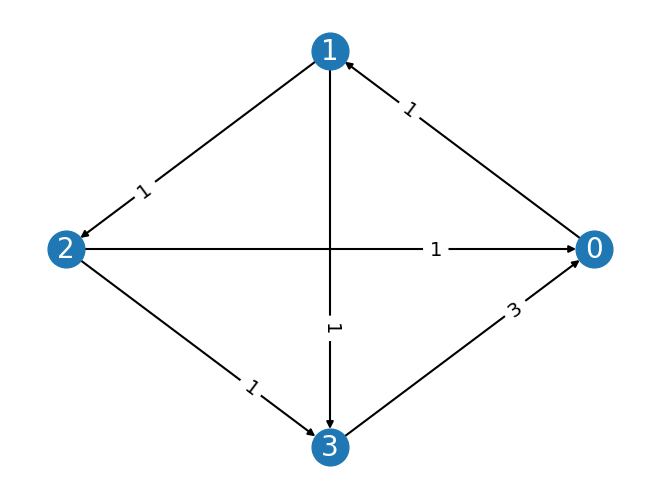

{0: 6, 1: 8, 2: 8, 3: 8}
c_ws [1, 2]
c_b_ws [1]
c_gb_ws [1, 2]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 2 | 1 | 2 |
| 1 | 0 | 0 | 2 | 3 |
| 2 | 3 | 3 | 0 | 0 |
| 3 | 2 | 1 | 3 | 1 |
+---+---+---+---+---+


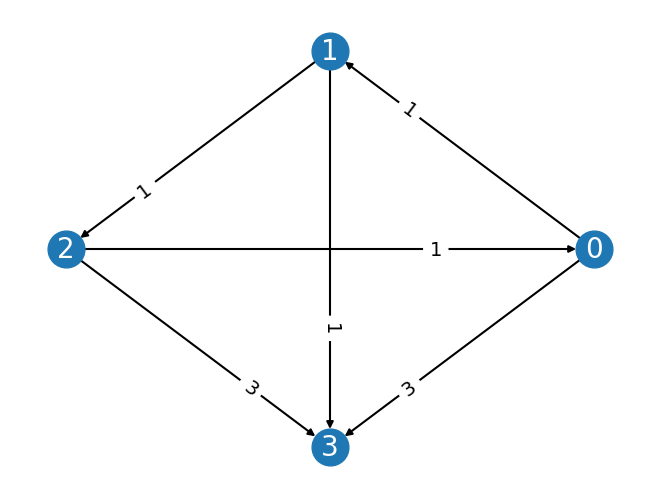

{0: 9, 1: 8, 2: 9, 3: 4}
c_ws [0, 1, 2]
c_b_ws [0, 1, 2]
c_gb_ws [0, 2]
+---+---+---+---+
| 2 | 1 | 1 | 1 |
+---+---+---+---+
| 3 | 0 | 2 | 0 |
| 1 | 2 | 3 | 1 |
| 2 | 3 | 0 | 2 |
| 0 | 1 | 1 | 3 |
+---+---+---+---+


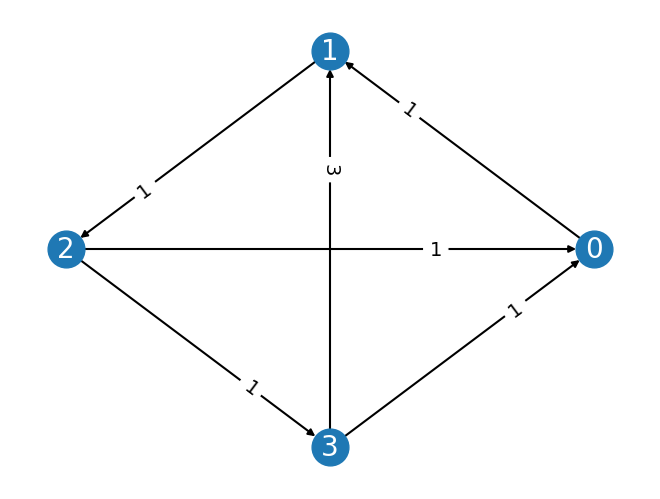

{0: 7, 1: 6, 2: 8, 3: 9}
c_ws [2, 3]
c_b_ws [2]
c_gb_ws [3]


In [6]:
for t in range(1000): 
    prof = generate_profile(4, 5) 
    #prof.display()
    c_ws = copeland(prof)
    c_b_ws = copeland_borda(prof)
    c_gb_ws = copeland_global_borda(prof)
    if c_b_ws != c_gb_ws:
        prof.display()
        prof.display_margin_graph()
        print(prof.borda_scores())
        print("c_ws", c_ws)
        print("c_b_ws", c_b_ws)
        print("c_gb_ws", c_gb_ws)

In [3]:
df = condorcet_efficiency_data([plurality, split_cycle],
    numbers_of_candidates=[3],
    numbers_of_voters=[4],
    probmods=["IC"],
    num_trials=10,
    use_parallel=True,
    num_cpus=5,
)

df

3 candidates, 4 voters


,vm,num_cands,num_voters,probmod,num_trials,percent_condorcet_winners,condorcet_efficiency
0,Plurality,3,4,IC,10,0.1,1.0
1,Split Cycle,3,4,IC,10,0.1,1.0


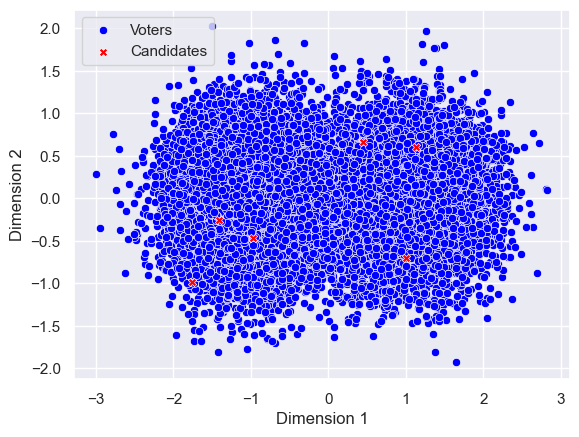

In [4]:
sp = generate_spatial_profile_polarized(
    [(np.array([1,0]), generate_covariance(2, 0.5, 0), 3), 
    (np.array([-1,0]), generate_covariance(2, 0.5, 0), 3)],
    [
    (np.array([1,0]), generate_covariance(2, 0.5, 0), 10000),
    (np.array([-1,0]), generate_covariance(2, 0.5, 0), 10000)]
    
    )



sp.view()

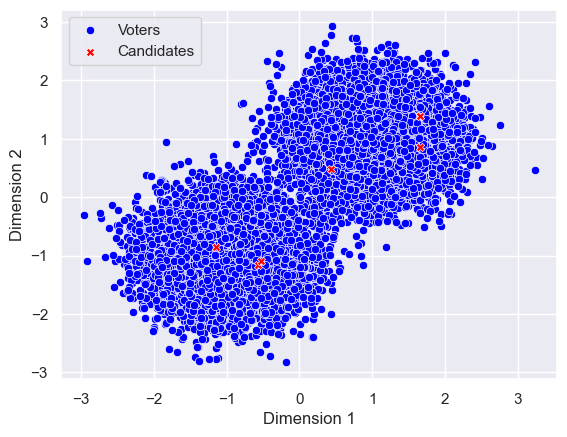

In [5]:
sp = generate_spatial_profile_polarized(
    [(np.array([1,1]), generate_covariance(2, 0.5, 0), 3), 
    (np.array([-1,-1]), generate_covariance(2, 0.5, 0), 3)],
    [
    (np.array([1,1]), generate_covariance(2, 0.5, 0), 10000),
    (np.array([-1,-1]), generate_covariance(2, 0.5, 0), 10000)]
    
    )

sp.view()

In [6]:
x = np.random.random(100)
y = np.random.random(100)


print("np.average(x)* np.average(y)", np.average(x) * np.average(y))
print("np.average(x * y)", np.average(x * y))
print()

print("np.average(x) / np.average(y)", np.average(x) / np.average(y))
print("np.average(x/y)", np.average(x/y))
print()

print("np.average(x) + np.average(y)", np.average(x) + np.average(y))
print("np.average(x +  y)", np.average(x + y))
print()

print("np.average(x) - np.average(y)", np.average(x) - np.average(y))
print("np.average(x - y)", np.average(x - y))


np.average(x)* np.average(y) 0.22446483744945547
np.average(x * y) 0.21536113592237766

np.average(x) / np.average(y) 1.0480735133287402
np.average(x/y) 41.866654417315296

np.average(x) + np.average(y) 0.9478155452092079
np.average(x +  y) 0.9478155452092077

np.average(x) - np.average(y) 0.022247650267077257
np.average(x - y) 0.02224765026707725


In [7]:
for t in tqdm(range(1000)): 

    prof = generate_profile(6, 500)

    cw = prof.condorcet_winner()
    woodall_ws = woodall(prof)

    river_ws = river_zt(prof)

    if cw is not None and [cw] != river_ws:
        print("ERROR")
        print("river: ", river_ws)
        print("cw: ", cw)
        prof.display_margin_graph()


  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
for t in tqdm(range(1000)): 

    prof = generate_profile(10, 1001)

    s_set = smith_set(prof)
    cw = prof.condorcet_winner()
    woodall_ws = woodall(prof)
    if (cw is not None and woodall_ws != [cw]) or any([w not in s_set for w in woodall_ws]): 
        print("ERROR")
        print("cw: ", cw)
        print("s_set: ", s_set)
        print("woodall_ws: ", woodall_ws)

  0%|          | 0/1000 [00:00<?, ?it/s]

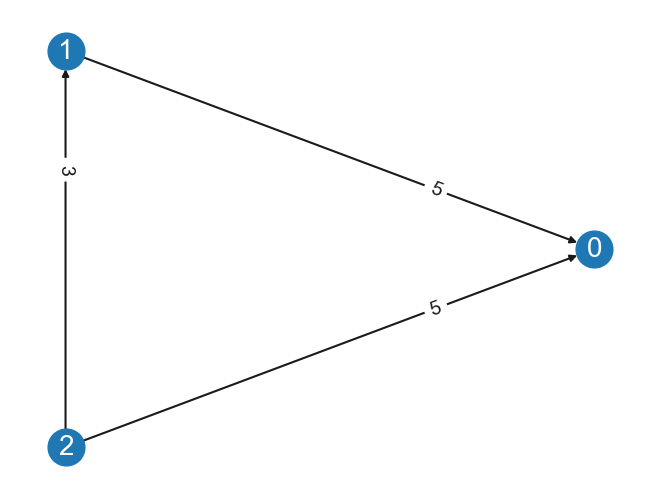

Copeland winner is {2}
{0: 0.0, 1: 0.0, 2: 1.0}
[2]
{0: -1.734723475976807e-17, 1: 0.0, 2: 1.0}
[2]


In [9]:
prof = generate_profile(3, 21)
prof.display_margin_graph()
copeland.display(prof)
print(c1_maximal_lottery(prof))
print(bipartisan(prof))
print(maximal_lottery(prof))
print(essential(prof))



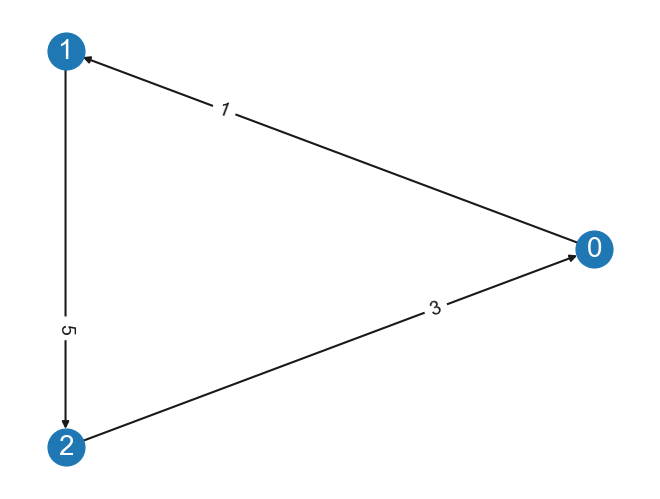

Zero sum game with payoff matrices:

Row player:
[[ 0  1 -3]
 [-1  0  5]
 [ 3 -5  0]]

Column player:
[[ 0 -1  3]
 [ 1  0 -5]
 [-3  5  0]]
(array([0.55555556, 0.33333333, 0.11111111]), array([0.55555556, 0.33333333, 0.11111111]))


In [10]:
mg = MarginGraph(
    [0, 1,2 ],
    [(0, 1, 1), 
    (1, 2, 5), 
    (2, 0, 3)]
)
mg.display()

A = np.array(mg.margin_matrix)

# Create the game
game = nash.Game(A)
print(game)
# Find the Nash Equilibrium with Support Enumeration
equilibria = game.support_enumeration()
for eq in equilibria:
    print(eq)



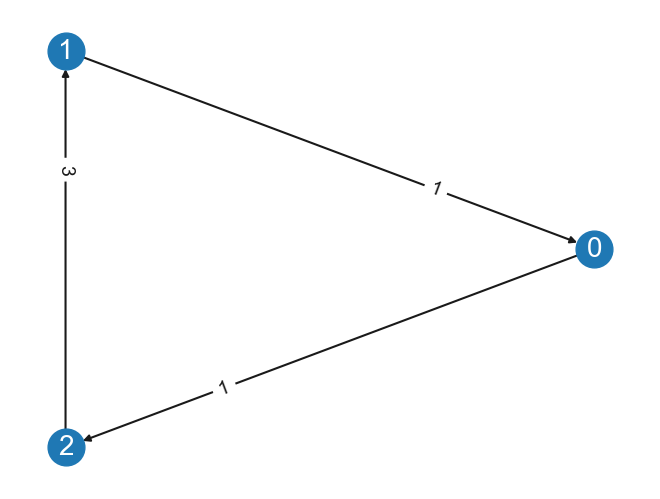

[[0, -1, 1], [1, 0, -3], [-1, 3, 0]]
Zero sum game with payoff matrices:

Row player:
[[ 0 -1  1]
 [ 1  0 -3]
 [-1  3  0]]

Column player:
[[ 0  1 -1]
 [-1  0  3]
 [ 1 -3  0]]
(array([0.6, 0.2, 0.2]), array([0.6, 0.2, 0.2]))


In [11]:


for t in range(1000): 

    prof = generate_profile(3, 5)
    if prof.condorcet_winner() is None:
        prof.display_margin_graph()

        print(prof.margin_graph().margin_matrix)
        # Define the payoff matrix for players
        # A and B should be square matrices where the dimension is equal to the number of actions
        A = np.array(prof.margin_matrix)
        B = -A  # For zero sum games, player 2's payoff matrix is the negative of player 1's

        # Create the game
        game = nash.Game(A)
        print(game)
        # Find the Nash Equilibrium with Support Enumeration
        equilibria = game.support_enumeration()
        for eq in equilibria:
            print(eq)

        break


In [12]:
for t in tqdm(range(1000)): 
    prof = generate_spatial_profile(10, 1001, 2).to_utility_profile().to_ranking_profile().to_linear_profile()

    A = np.array(prof.margin_matrix)

    game = nash.Game(A)
    equilibria = list(game.vertex_enumeration())

    if len(equilibria) != 1: 
        prof.display_margin_graph()
        print(prof.margin_matrix)
        print(equilibria)



  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
prof = generate_profile(4, 4)

prof.display()
print(prof.borda_scores())


print(random_dictator(prof))
print(random_dictator.name)
print(pr_borda(prof))

+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 3 | 1 | 3 |
| 3 | 2 | 0 | 1 |
| 0 | 0 | 2 | 0 |
| 2 | 1 | 3 | 2 |
+---+---+---+---+
{0: 5, 1: 8, 2: 3, 3: 8}
{0: 0.0, 1: 0.5, 2: 0.0, 3: 0.5}
Random Dictator
{0: 0.20833333333333334, 1: 0.3333333333333333, 2: 0.125, 3: 0.3333333333333333}


In [7]:
uprof = UtilityProfile([{0: u, 1: 20*u, 2: 30*u} for u in  [50, 60, 70, 80, 90, 100, 110]])

uprof.display()

uprof.normalize_by_range().display()

uprof.normalize_by_standard_score().display()

util_avg = uprof.avg_utility_function()

for x in uprof.domain: 
    print(x, util_avg(x))

  Voter    0     1     2
-------  ---  ----  ----
      1   50  1000  1500
      2   60  1200  1800
      3   70  1400  2100
      4   80  1600  2400
      5   90  1800  2700
      6  100  2000  3000
      7  110  2200  3300
  Voter    0         1    2
-------  ---  --------  ---
      1    0  0.655172    1
      2    0  0.655172    1
      3    0  0.655172    1
      4    0  0.655172    1
      5    0  0.655172    1
      6    0  0.655172    1
      7    0  0.655172    1
  Voter         0         1        2
-------  --------  --------  -------
      1  -1.33026  0.249423  1.08083
      2  -1.33026  0.249423  1.08083
      3  -1.33026  0.249423  1.08083
      4  -1.33026  0.249423  1.08083
      5  -1.33026  0.249423  1.08083
      6  -1.33026  0.249423  1.08083
      7  -1.33026  0.249423  1.08083
0 80.0
1 1600.0
2 2400.0


In [8]:
up = generate_spatial_profile(3, 3, 2).to_utility_profile()

up.display()
up.normalize_by_range().display()

up.normalize_by_standard_score().display()

  Voter         0         1         2
-------  --------  --------  --------
      1  -1.275    -1.72293  -0.61269
      2  -8.18314  -4.67643  -8.60475
      3  -3.90325  -2.87746  -4.48158
  Voter         0    1    2
-------  --------  ---  ---
      1  0.403456    0    1
      2  0.107327    1    0
      3  0.360529    1    0
  Voter          0         1          2
-------  ---------  --------  ---------
      1  -0.156686  -1.13886   1.29555
      2  -0.584004   1.40744  -0.823437
      3  -0.224858   1.32159  -1.09674


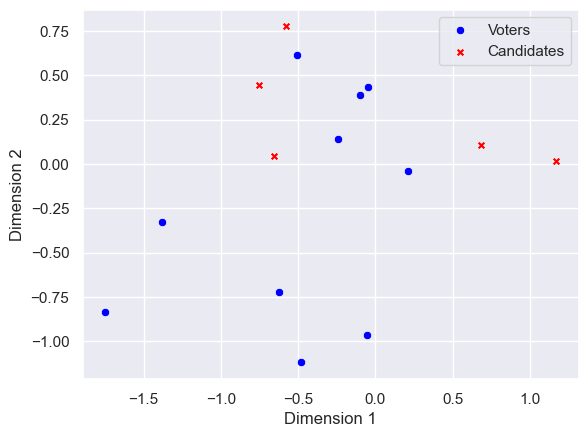

In [9]:
sp = generate_spatial_profile(5, 10, 2)

sp.view()

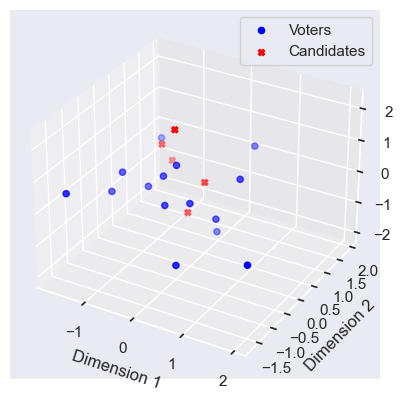

Candidates: 
Candidate  0  position:  [ 0.10522923 -0.25501962 -0.34295376]
Candidate  1  position:  [-0.55442734  0.31580755  0.5750867 ]
Candidate  2  position:  [-0.66575182  0.15089086  1.16203326]
Candidate  3  position:  [-0.07557005 -0.3766908   2.25746106]
Candidate  4  position:  [0.28376736 0.02745984 0.46916251]

Voters: 
Voter  0  position:  [-0.20812505 -0.51393988 -0.04865335]
Voter  1  position:  [ 0.51845401 -1.34516598 -0.90636831]
Voter  2  position:  [0.767884   0.4271824  0.46792384]
Voter  3  position:  [ 0.36579495  0.27895542 -0.87337764]
Voter  4  position:  [ 1.96722033 -1.43471314 -0.11237555]
Voter  5  position:  [-1.00393102  0.22118074 -0.38457075]
Voter  6  position:  [0.23688359 1.91097068 0.15802877]
Voter  7  position:  [ 0.15810914 -0.2716462  -0.01581822]
Voter  8  position:  [-0.27694568  0.00175634  0.77930153]
Voter  9  position:  [-1.47282449 -1.68085487  0.68792794]
Voter  10  position:  [-0.0122813   0.97349124 -2.0371548 ]
Voter  11  position: 

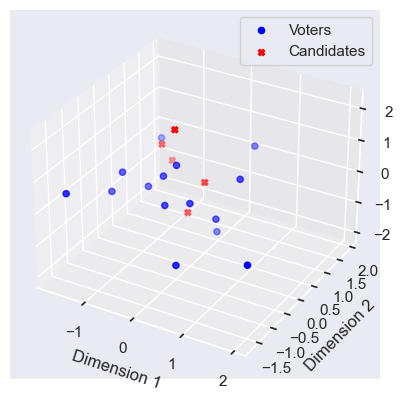

Candidates: 
Candidate  0  position:  [ 0.10522923 -0.25501962 -0.34295376]
Candidate  1  position:  [-0.55442734  0.31580755  0.5750867 ]
Candidate  2  position:  [-0.66575182  0.15089086  1.16203326]
Candidate  3  position:  [-0.07557005 -0.3766908   2.25746106]
Candidate  4  position:  [0.28376736 0.02745984 0.46916251]

Voters: 
Voter  0  position:  [-0.20812505 -0.51393988 -0.04865335]
Voter  1  position:  [ 0.51845401 -1.34516598 -0.90636831]
Voter  2  position:  [0.767884   0.4271824  0.46792384]
Voter  3  position:  [ 0.36579495  0.27895542 -0.87337764]
Voter  4  position:  [ 1.96722033 -1.43471314 -0.11237555]
Voter  5  position:  [-1.00393102  0.22118074 -0.38457075]
Voter  6  position:  [0.23688359 1.91097068 0.15802877]
Voter  7  position:  [ 0.15810914 -0.2716462  -0.01581822]
Voter  8  position:  [-0.27694568  0.00175634  0.77930153]
Voter  9  position:  [-1.47282449 -1.68085487  0.68792794]
Voter  10  position:  [-0.0122813   0.97349124 -2.0371548 ]
Voter  11  position: 

In [10]:
sp = generate_spatial_profile(5, 15, 3)
sp.view()
sp.display()
sp_str = sp.write()

sp2 = SpatialProfile.from_string(sp_str)

sp2.view()
sp2.display()


In [11]:
for t in range(100): 
    prof = generate_profile(4, 11)  
    print(split_cycle(prof)  ) 

[1]
[0, 1, 2]
[3]
[3]
[1]
[1]
[2]
[0]
[3]
[1]
[0]
[1, 2, 3]
[0, 1, 3]
[0]
[1]
[3]
[2, 3]
[1, 3]
[2]
[1]
[2]
[0, 1, 2]
[3]
[0]
[2]
[1]
[0, 2]
[3]
[0]
[0]
[0]
[2]
[1]
[0]
[2]
[2]
[3]
[0]
[2]
[2]
[0]
[1]
[0, 1, 2, 3]
[3]
[3]
[0]
[2]
[0]
[1]
[3]
[2]
[2]
[2]
[3]
[0]
[1]
[1]
[1]
[3]
[3]
[1]
[2]
[3]
[0, 3]
[2, 3]
[1, 3]
[0]
[3]
[2]
[3]
[3]
[0]
[1]
[3]
[1]
[1]
[0]
[0]
[1]
[2]
[1, 2, 3]
[3]
[2]
[2]
[2]
[1]
[0]
[2]
[1]
[2]
[3]
[0]
[0]
[2]
[1]
[0]
[3]
[1]
[3]
[0, 1, 2]


In [12]:

for t in range(100):
    for vm in [split_cycle, 
               stable_voting, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               simple_stable_voting, 
               copeland,
               borda, 
               plurality, 
               plurality_with_runoff_put, 
               instant_runoff, 
               coombs, 
               minimax, 
               strict_nanson, 
               bucklin]: 

        prof = generate_profile(5, 11)

        vm.display(prof)
        
        prof = generate_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()




Split Cycle winner is {0}
Split Cycle winners are {1, 3}
Stable Voting winner is {2}
Stable Voting winner is {0}
Beat Path winner is {2}
Beat Path winners are {0, 1, 2, 4}
Beat Path winner is {0}
Beat Path winner is {3}
Split Cycle winner is {2}
Split Cycle winners are {1, 2}
Simple Stable Voting winner is {0}
Simple Stable Voting winner is {3}
Copeland winner is {4}
Copeland winner is {2}
Borda winner is {4}
Borda winner is {4}
Plurality winner is {0}
Plurality winner is {4}
PluralityWRunoff PUT winner is {2}
PluralityWRunoff PUT winners are {3, 4}
Instant Runoff winner is {1}
Instant Runoff winner is {0}
Coombs winner is {3}
Coombs winner is {0}
Minimax winner is {3}
Minimax winner is {1}
Strict Nanson winner is {4}
Strict Nanson winner is {0}
Bucklin winner is {2}
Bucklin winner is {1}

Split Cycle winner is {2}
Split Cycle winner is {1}
Stable Voting winner is {2}
Stable Voting winner is {0}
Beat Path winner is {2}
Beat Path winner is {3}
Beat Path winners are {0, 1, 2, 4}
Beat Pat

In [13]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               plurality,
               stable_voting, 
               simple_stable_voting, 
               copeland,
               borda_for_profile_with_ties,
               instant_runoff_for_truncated_linear_orders
               ]: 

        prof = generate_truncated_profile(5, 11)

        vm.display(prof)
        prof = generate_truncated_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


Split Cycle winner is {0}
Split Cycle winners are {0, 1, 2}
Beat Path winner is {0}
Beat Path winners are {1, 2, 4}
Beat Path winner is {0}
Beat Path winners are {1, 2}
Split Cycle winner is {3}
Split Cycle winner is {1}
Plurality winner is {1}
Plurality winner is {3}
Stable Voting winner is {3}
Stable Voting winner is {1}
Simple Stable Voting winner is {2}
Simple Stable Voting winner is {0}
Copeland winner is {3}
Copeland winners are {1, 3}
Borda winner is {3}
Borda winners are {1, 4}
Instant Runoff winners are {2, 4}
Instant Runoff winner is {0}

Split Cycle winners are {1, 3}
Split Cycle winner is {3}
Beat Path winners are {1, 2}
Beat Path winners are {1, 3}
Beat Path winners are {3, 4}
Beat Path winner is {1}
Split Cycle winner is {4}
Split Cycle winners are {3, 4}
Plurality winners are {1, 2, 3}
Plurality winner is {1}
Stable Voting winner is {4}
Stable Voting winner is {0}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {3}
Copeland winner is {2}
Copeland winner

In [14]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               stable_voting, 
               simple_stable_voting, 
               gocha,
               smith_set,
               copeland
               ]: 

        mg = generate_margin_graph(5)

        vm.display(mg)
        mg = generate_edge_ordered_tournament(4)
        vm.display(mg)

        mg = generate_edge_ordered_tournament_infinite_limit(5)
        vm.display(mg)


        ws_restricted = vm(mg, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


Split Cycle winner is {4}
Split Cycle winner is {1}
Split Cycle winner is {0}
Beat Path winner is {3}
Beat Path winner is {1}
Beat Path winner is {1}
Beat Path winner is {4}
Beat Path winner is {2}
Beat Path winner is {3}
Split Cycle winner is {3}
Split Cycle winner is {1}
Split Cycle winner is {4}
Stable Voting winner is {3}
Stable Voting winner is {1}
Stable Voting winner is {3}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {3}
Simple Stable Voting winner is {1}
GOCHA winner is {4}
GOCHA winner is {1}
GOCHA winner is {4}
Smith Set winner is {4}
Smith Set winners are {0, 1, 2, 3}
Smith Set winner is {1}
Copeland winner is {4}
Copeland winners are {0, 3}
Copeland winner is {1}

Split Cycle winner is {2}
Split Cycle winner is {2}
Split Cycle winner is {1}
Beat Path winner is {2}
Beat Path winner is {3}
Beat Path winner is {1}
Beat Path winner is {1}
Beat Path winner is {0}
Beat Path winner is {1}
Split Cycle winners are {1, 2}
Split Cycle winner is {0}
Split Cycle wi

In [16]:
for t in range(100):
    for um in [sum_utilitarian,
                relative_utilitarian,
                maximin,
                lexicographic_maximin,
                nash_bargaining,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        print(um(uprof))

        uprof = generate_utility_profile_normal(6, 20)
        print(um(uprof))

        uprof = generate_spatial_utility_profile(5, 11)
        print(um(uprof))

    print()


1 0 3 4 2 
2 3 0 4 1 5 
3 1 4 2 0 
0 3 4 1 2 
4 0 2 1 5 3 
4 1 3 2 0 
0 1 2 4 3 
1 4 5 2 3 0 
1 0 4 3 2 
3 0 2 1 4 
0 2 4 3 1 5 
2 0 3 1 4 
0 
1 4 2 3 0 
0 

2 0 3 4 1 
2 4 5 3 0 1 
4 2 0 1 3 
3 1 4 2 0 
2 3 1 4 0 5 
1 4 2 0 3 
1 3 2 0 4 
4 3 2 1 5 0 
0 4 1 2 3 
4 3 0 2 1 
3 1 0 2 4 5 
0 4 3 1 2 
0 
4 5 1 0 
0 

1 0 3 2 4 
1 3 2 0 5 4 
2 3 0 4 1 
2 1 4 3 0 
0 2 5 1 3 4 
4 2 0 3 1 
1 0 3 4 2 
2 3 0 1 4 5 
0 3 2 1 4 
1 3 0 4 2 
5 0 3 4 1 2 
0 3 2 1 4 
0 
4 5 2 0 
0 

1 0 3 2 4 
5 0 1 3 2 4 
0 2 4 1 3 
3 4 0 1 2 
4 3 2 5 1 0 
1 4 0 2 3 
0 4 2 3 1 
1 3 2 5 4 0 
1 0 4 2 3 
4 1 2 3 0 
3 2 5 4 0 1 
0 1 4 2 3 
0 
4 1 0 
0 

3 0 4 1 2 
2 4 0 5 3 1 
0 3 1 4 2 
1 0 4 3 2 
2 5 4 3 0 1 
3 4 1 2 0 
1 4 2 0 3 
4 2 3 5 0 1 
1 2 3 4 0 
2 4 0 3 1 
3 4 1 5 2 0 
3 4 0 1 2 
0 
1 5 2 0 
0 

0 4 1 2 3 
5 3 2 1 0 4 
3 1 2 0 4 
3 2 1 4 0 
2 3 5 4 1 0 
1 0 3 4 2 
3 0 2 1 4 
1 3 0 2 4 5 
2 0 4 3 1 
1 4 0 3 2 
3 2 4 0 5 1 
1 4 2 0 3 
0 
0 
0 

1 2 3 4 0 
1 3 2 4 5 0 
0 1 2 4 3 
2 4 1 0 3 
0 2 4 3 1 5 
1 0 4 3 2 


In [17]:
for t in range(100):
    for vm in [sum_utilitarian_ws,
                relative_utilitarian_ws,
                maximin_ws,
                lexicographic_maximin_ws,
                nash_ws,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        vm.display(uprof)

        uprof = generate_utility_profile_normal(6, 20)
        vm.display(uprof)

        uprof = generate_spatial_utility_profile(5, 11)
        vm.display(uprof)

        ws_restricted = vm(uprof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()


Sum Utilitarianism winner is {2}
Sum Utilitarianism winner is {4}
Sum Utilitarianism winner is {3}
Relative Utilitarianism winner is {1}
Relative Utilitarianism winner is {1}
Relative Utilitarianism winner is {0}
Maximin winner is {1}
Maximin winner is {1}
Maximin winner is {3}
Lexicographic Maximin winner is {3}
Lexicographic Maximin winner is {5}
Lexicographic Maximin winner is {4}
Nash winner is {0}
Nash winner is {2}
Nash winner is {0}

Sum Utilitarianism winner is {2}
Sum Utilitarianism winner is {0}
Sum Utilitarianism winner is {2}
Relative Utilitarianism winner is {0}
Relative Utilitarianism winner is {2}
Relative Utilitarianism winner is {2}
Maximin winner is {3}
Maximin winner is {5}
Maximin winner is {3}
Lexicographic Maximin winner is {4}
Lexicographic Maximin winner is {4}
Lexicographic Maximin winner is {2}
Nash winner is {0}
Nash winner is {0}
Nash winner is {0}

Sum Utilitarianism winner is {4}
Sum Utilitarianism winner is {3}
Sum Utilitarianism winner is {2}
Relative Ut

In [21]:
max([1, 1, 3, 3])

3

In [18]:
def f(): 
    return 1

f.name = "hello"



In [19]:
f.name

'hello'